# GAN


In [0]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

1.15.0


Using TensorFlow backend.


### Dataframe


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/im-p/synteettinen_data/master/bmi_data_events.csv")
df

,patient_id,Gender,Height,Weight,bmi,bmi_class,2017,2018,2019,2020
0,90329,Male,1.875714,109.721075,31.19,severely overweight,laakarikaynti 2,laakarikaynti 4,laakarikaynti 2,laakarikaynti 1
1,82793,Male,1.747060,73.622792,24.12,healthy,ei jatkotoimenpiteita,laakarikaynti 1,ei jatkotoimenpiteita,ei jatkotoimenpiteita
2,98691,Male,1.882397,96.497629,27.23,overweight,laakarikaynti 2,laakarikaynti 1,laakarikaynti 1,laakarikaynti 2
3,20430,Male,1.821967,99.809586,30.07,severely overweight,laakarikaynti 1,ei jatkotoimenpiteita,laakarikaynti 2,ei jatkotoimenpiteita
4,96554,Male,1.774998,93.598695,29.71,overweight,laakarikaynti 4,laakarikaynti 4,laakarikaynti 4,laakarikaynti 3
...,...,...,...,...,...,...,...,...,...,...
9995,51506,Female,1.680785,62.041210,21.96,healthy,ei jatkotoimenpiteita,ei jatkotoimenpiteita,laakarikaynti 1,ei jatkotoimenpiteita
9996,38900,Female,1.703506,77.504378,26.71,overweight,laakarikaynti 3,laakarikaynti 2,laakarikaynti 4,ei jatkotoimenpiteita
9997,26718,Female,1.622247,58.275424,22.14,healthy,ei jatkotoimenpiteita,ei jatkotoimenpiteita,ei jatkotoimenpiteita,laakarikaynti 1
9998,67447,Female,1.753470,74.322226,24.17,healthy,ei jatkotoimenpiteita,laakarikaynti 1,laakarikaynti 1,ei jatkotoimenpiteita


#### Categorical and numerical data

In [0]:
numerical_data = df.select_dtypes("number")
categorical_data = df.select_dtypes("object")
numerical_data

,patient_id,Height,Weight,bmi
0,90329,1.875714,109.721075,31.19
1,82793,1.747060,73.622792,24.12
2,98691,1.882397,96.497629,27.23
3,20430,1.821967,99.809586,30.07
4,96554,1.774998,93.598695,29.71
...,...,...,...,...
9995,51506,1.680785,62.041210,21.96
9996,38900,1.703506,77.504378,26.71
9997,26718,1.622247,58.275424,22.14
9998,67447,1.753470,74.322226,24.17


In [0]:
categorical_data

,Gender,bmi_class,2017,2018,2019,2020
0,Male,severely overweight,laakarikaynti 2,laakarikaynti 4,laakarikaynti 2,laakarikaynti 1
1,Male,healthy,ei jatkotoimenpiteita,laakarikaynti 1,ei jatkotoimenpiteita,ei jatkotoimenpiteita
2,Male,overweight,laakarikaynti 2,laakarikaynti 1,laakarikaynti 1,laakarikaynti 2
3,Male,severely overweight,laakarikaynti 1,ei jatkotoimenpiteita,laakarikaynti 2,ei jatkotoimenpiteita
4,Male,overweight,laakarikaynti 4,laakarikaynti 4,laakarikaynti 4,laakarikaynti 3
...,...,...,...,...,...,...
9995,Female,healthy,ei jatkotoimenpiteita,ei jatkotoimenpiteita,laakarikaynti 1,ei jatkotoimenpiteita
9996,Female,overweight,laakarikaynti 3,laakarikaynti 2,laakarikaynti 4,ei jatkotoimenpiteita
9997,Female,healthy,ei jatkotoimenpiteita,ei jatkotoimenpiteita,ei jatkotoimenpiteita,laakarikaynti 1
9998,Female,healthy,ei jatkotoimenpiteita,laakarikaynti 1,laakarikaynti 1,ei jatkotoimenpiteita


### Data preprocessing

#### numerical data

In [0]:
#Rescaleing data between 0-1
mms = MinMaxScaler()
numerical_data_rescaled = mms.fit_transform(numerical_data)
numerical_data_rescaled

array([[0.90343165, 0.79172838, 0.863139  , 0.89533561],
       [0.82805733, 0.58695829, 0.4754764 , 0.49317406],
       [0.98706754, 0.8023644 , 0.72113127, 0.67007964],
       ...,
       [0.26720077, 0.38830089, 0.31065968, 0.38054608],
       [0.67456817, 0.59715974, 0.48298768, 0.4960182 ],
       [0.70073314, 0.31052854, 0.23843869, 0.30546075]])

#### Categorical data

In [0]:
ohe_data = pd.get_dummies(categorical_data)
ohe_data

,Gender_Female,Gender_Male,bmi_class_healthy,bmi_class_overweight,bmi_class_severely overweight,bmi_class_underweight,2017_ei jatkotoimenpiteita,2017_laakarikaynti 1,2017_laakarikaynti 2,2017_laakarikaynti 3,2017_laakarikaynti 4,2018_ei jatkotoimenpiteita,2018_laakarikaynti 1,2018_laakarikaynti 2,2018_laakarikaynti 3,2018_laakarikaynti 4,2019_ei jatkotoimenpiteita,2019_laakarikaynti 1,2019_laakarikaynti 2,2019_laakarikaynti 3,2019_laakarikaynti 4,2020_ei jatkotoimenpiteita,2020_laakarikaynti 1,2020_laakarikaynti 2,2020_laakarikaynti 3,2020_laakarikaynti 4
0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9996,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
9997,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
9998,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0


In [0]:
gender_ohe = ohe_data.iloc[:, 0:2]
bmi_class_ohe = ohe_data.iloc[:, 2:6]
events_ohe = ohe_data.iloc[:, 6:]

In [0]:
print("numerical data shape:", numerical_data_rescaled.shape)
print("gender ohe data shape:", gender_ohe.shape)
print("bmi class ohe data shape:", bmi_class_ohe.shape)
print("events ohe data shape:", events_ohe.shape)

numerical data shape: (10000, 4)
gender ohe data shape: (10000, 2)
bmi class ohe data shape: (10000, 4)
events ohe data shape: (10000, 20)


# GAN for generating numerical data

#### Generator
 * Generator takes input from the random normal distribution (latent_dim)
 * Output the same number of columns as the original (n_columns)
 * Generator will not be compiled, because we update generator based on the discriminators error


In [0]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

#### Initialize generator and plot model

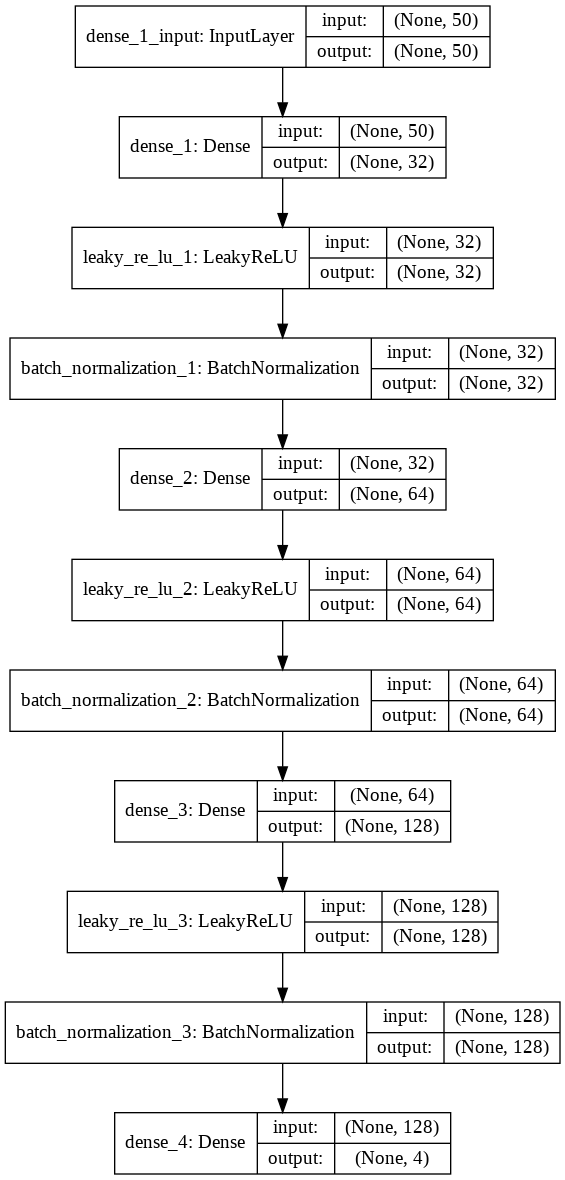

In [0]:
latent_dim = 50
generator = build_generator(numerical_data_rescaled.shape[1], latent_dim)
plot_model(generator, show_layer_names = True, show_shapes = True)

#### Discriminator
 * Dicscriminator input is the generator output
 * Outputs classification (real or generated data)

In [0]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [0]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

#### Initialize discriminator and plot model




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


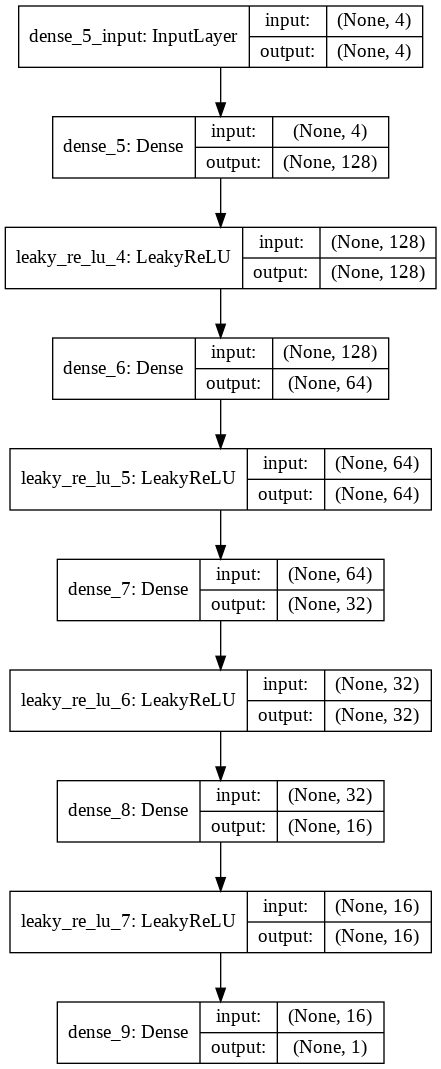

In [0]:
discriminator = build_discriminator(numerical_data_rescaled.shape[1])
plot_model(discriminator, show_layer_names = True, show_shapes = True)

#### GAN
 * Satck generator and discriminator
 * GAN input is generator input
 * GAN output classification generated or original data (discriminator output)
 * We use gan function to train generator in training loop based on the classification error

In [0]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

#### Compile GAN and plot model

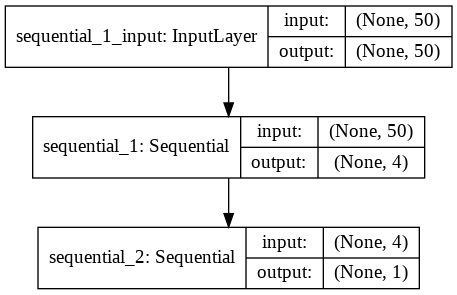

In [0]:
gan = build_gan(generator, discriminator)
plot_model(gan, show_layer_names = True, show_shapes = True)

#### GAN training

In [0]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 250 [Generator loss: 0.692752] [Discriminator loss: 0.689638]
Epoch: 500 [Generator loss: 0.700666] [Discriminator loss: 0.690210]
Epoch: 750 [Generator loss: 0.707478] [Discriminator loss: 0.692872]
Epoch: 1000 [Generator loss: 0.700812] [Discriminator loss: 0.693722]
Epoch: 1250 [Generator loss: 0.696290] [Discriminator loss: 0.693853]
Epoch: 1500 [Generator loss: 0.695631] [Discriminator loss: 0.694164]
Epoch: 1750 [Generator loss: 0.694394] [Discriminator loss: 0.694034]
Epoch: 2000 [Generator loss: 0.690796] [Discriminator loss: 0.694117]
Epoch: 2250 [Generator loss: 0.689114] [Discriminator loss: 0.694086]
Epoch: 2500 [Generator loss: 0.689568] [Discriminator loss: 0.693856]
Epoch: 2750 [Generator loss: 0.688964] [Discriminator loss: 0.693701]
Epoch: 3000 [Generator loss: 0.691874] [Discriminator loss: 0.693466]
Epoch: 3250 [Generator loss: 0.692807] [Discriminator loss: 0.693696]
Epoch: 3500 [Generator loss: 0.690907] [Discriminator loss: 0.693512]
Epoch: 3750 [Generator 

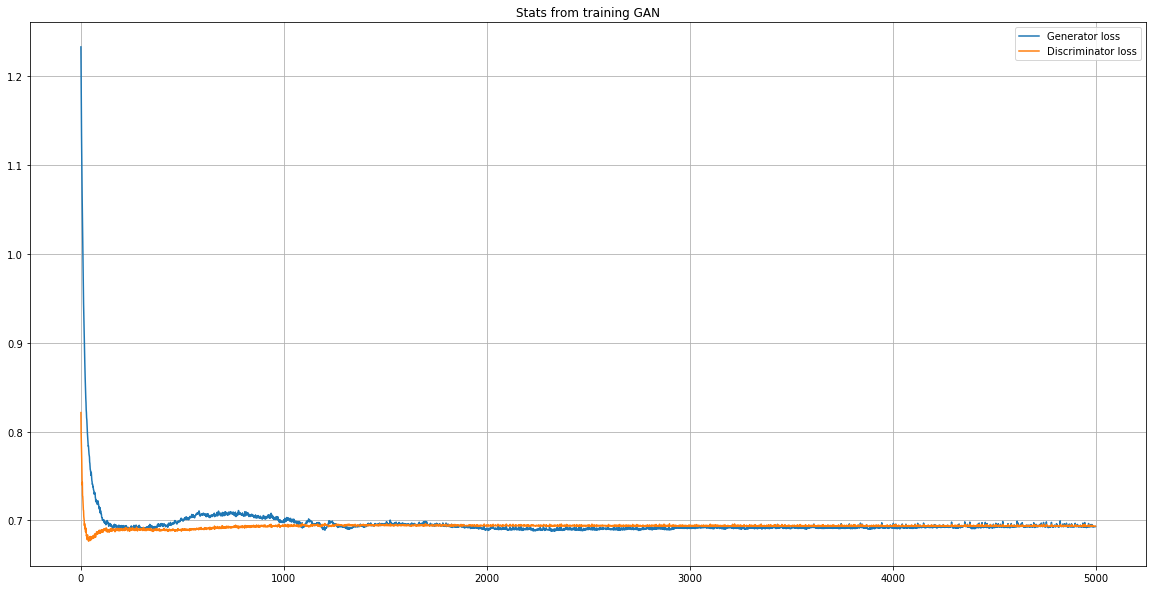

In [0]:
train(gan, generator, discriminator, numerical_data_rescaled, latent_dim, n_epochs = 5000, n_batch = 1024, n_eval = 250)

### Generating numerical data with generator




In [0]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

array([[0.15321296, 0.46257776, 0.3876037 , 0.4461066 ],
       [0.3510152 , 0.4957723 , 0.40183526, 0.45575505],
       [0.52322143, 0.5801354 , 0.5952139 , 0.7163593 ],
       ...,
       [0.9084321 , 0.24215817, 0.20422834, 0.29189658],
       [0.08021015, 0.29829642, 0.22115415, 0.26953667],
       [0.64476985, 0.6214607 , 0.5681896 , 0.6198517 ]], dtype=float32)

### Converting the generated data to similar as the original

In [0]:
generated_numerical_data = mms.inverse_transform(generated_numerical_data)
gen_df = pd.DataFrame(data = generated_numerical_data, columns = numerical_data.columns)
gen_df

,patient_id,Height,Weight,bmi
0,15321.385742,1.668914,65.440277,23.292553
1,35097.851562,1.689770,66.765488,23.462173
2,52315.199219,1.742774,84.772476,28.043596
3,33206.734375,1.627241,56.365398,21.111996
4,61771.718750,1.709197,81.052765,27.745068
...,...,...,...,...
9995,14456.940430,1.631306,72.679932,27.473936
9996,3687.655029,1.747826,87.184990,28.467550
9997,90828.953125,1.530428,48.364773,20.581543
9998,8022.490723,1.565699,49.940865,20.188454


### Comaparing original and generated data
 * Normal distribution
 * mean, std, var
 * correlation matrix

In [0]:
def normal_distribution(r, f):

	r_x = np.linspace(r.min(), r.max(), len(r))
	f_x = np.linspace(f.min(), f.max(), len(f))

	r_y = scipy.stats.norm.pdf(r_x, r.mean(), r.std())
	f_y = scipy.stats.norm.pdf(f_x, f.mean(), f.std())
 
	n, bins, patches = plt.hist([r, f], density = True, alpha = 0.5, color = ["green", "red"])
	xmin, xmax = plt.xlim()

	plt.plot(r_x, r_y, color = "green", label = "Original data", alpha = 0.5)
	plt.plot(f_x, f_y, color = "red", label = "Generated data", alpha = 0.5)
	title = f"Original data mean {np.round(r.mean(), 4)}, Original data std {np.round(r.std(), 4)}, Original data var {np.round(r.var(), 4)}\nGenerated data mean {np.round(f.mean(), 4)}, Generated data {np.round(f.std(), 4)}, Generated data var {np.round(f.var(), 2)}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()
 

patient_id Normal distribution


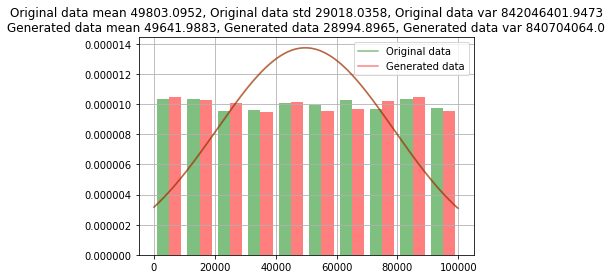

Height Normal distribution


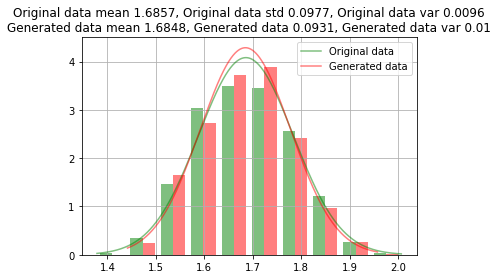

Weight Normal distribution


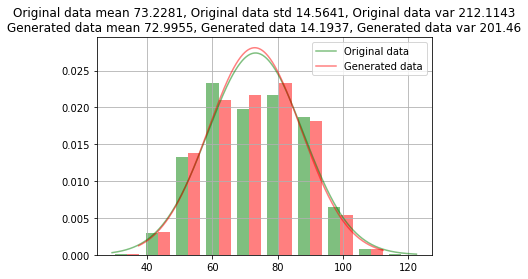

bmi Normal distribution


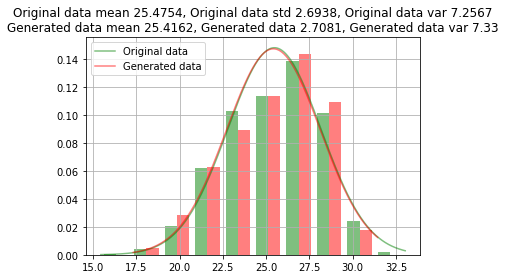

In [0]:
for column in gen_df.columns:
    print(column, "Normal distribution")
    normal_distribution(numerical_data[column], gen_df[column])

Original data


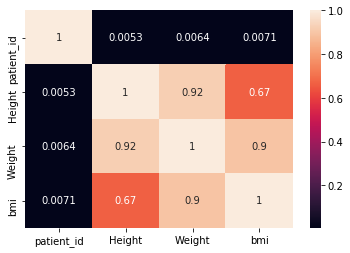

In [0]:
#correlation matrix compareing
print("Original data")
sns.heatmap(numerical_data.corr(), annot = True)

Generated data


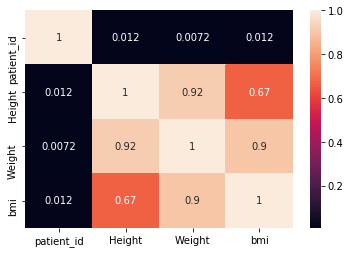

In [0]:
print("Generated data")
sns.heatmap(gen_df.corr(), annot = True)

# *Results*
 * normal distribution, mean, standard deviation and variance are very similar compared to the original
 * The correlation is very similar compared to the original


--------------------------------------------------------------------------------

# GAN for categorical data
 * from the first example change only the generators last activation function to softmax and change discriminator input size to correspond to generator output
 * Testing heterogeneous and homogeneous data

##### heterogeneous data

#### Generator

In [0]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim = latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(8,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(n_columns, activation = "softmax"))
    return model

In [0]:
latent_dim = 100
generator2 = build_generator(bmi_class_ohe.shape[1], latent_dim)

####Discriminator

In [0]:
discriminator2 = build_discriminator(bmi_class_ohe.shape[1])

#### GAN and training

In [0]:
gan2 = build_gan(generator2, discriminator2)

Epoch: 100 [Generator loss: 0.714700] [Discriminator loss: 0.688783]
Epoch: 200 [Generator loss: 0.715091] [Discriminator loss: 0.688285]
Epoch: 300 [Generator loss: 0.715068] [Discriminator loss: 0.687854]
Epoch: 400 [Generator loss: 0.714152] [Discriminator loss: 0.687839]
Epoch: 500 [Generator loss: 0.714033] [Discriminator loss: 0.686781]
Epoch: 600 [Generator loss: 0.714147] [Discriminator loss: 0.686962]
Epoch: 700 [Generator loss: 0.714761] [Discriminator loss: 0.687270]
Epoch: 800 [Generator loss: 0.714418] [Discriminator loss: 0.687299]
Epoch: 900 [Generator loss: 0.714241] [Discriminator loss: 0.687551]
Epoch: 1000 [Generator loss: 0.713843] [Discriminator loss: 0.686919]
Epoch: 1100 [Generator loss: 0.713712] [Discriminator loss: 0.686342]
Epoch: 1200 [Generator loss: 0.714151] [Discriminator loss: 0.685900]
Epoch: 1300 [Generator loss: 0.713388] [Discriminator loss: 0.688188]
Epoch: 1400 [Generator loss: 0.714334] [Discriminator loss: 0.688902]
Epoch: 1500 [Generator loss: 

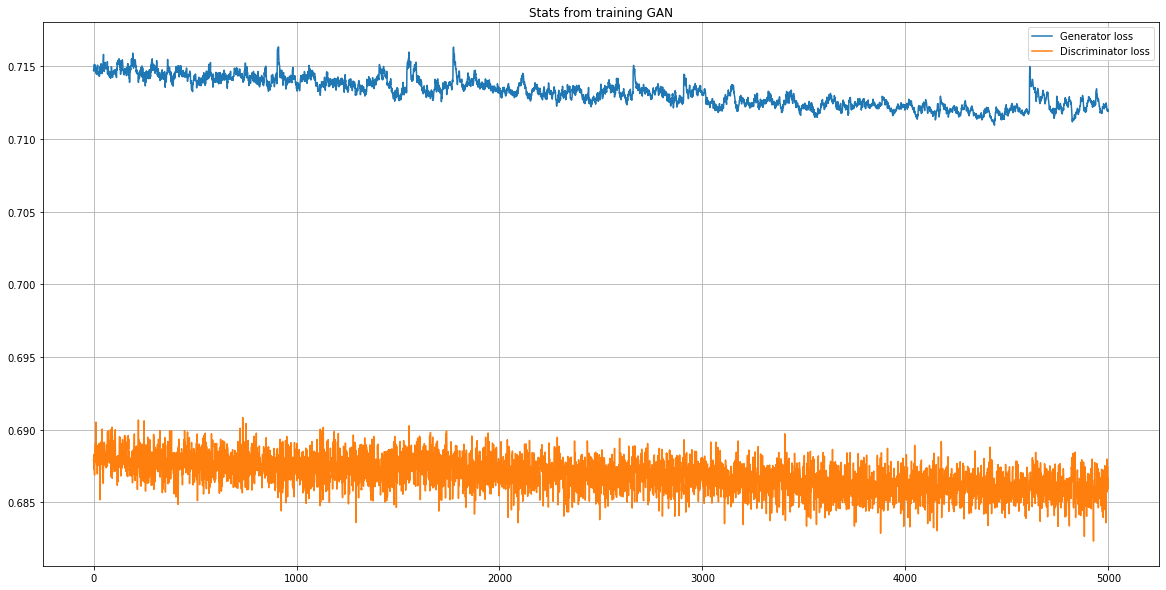

In [0]:
train(gan2, generator2, discriminator2, bmi_class_ohe.values, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

### Generating heterogeneous categorical data with generator 

In [0]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_categorical_data = generator2.predict(noise)
generated_categorical_data

array([[7.4237496e-06, 9.9998379e-01, 6.6982466e-06, 2.1381011e-06],
       [4.0223238e-08, 9.9999905e-01, 6.2216714e-07, 3.7322494e-07],
       [1.0000000e+00, 9.0978386e-18, 3.0524983e-09, 3.7104322e-10],
       ...,
       [1.1083174e-10, 1.0000000e+00, 8.3294704e-09, 1.1884604e-08],
       [3.2747508e-08, 9.9999893e-01, 6.3820426e-07, 4.5642687e-07],
       [5.8153881e-07, 9.9999774e-01, 8.7461643e-07, 8.4739696e-07]],
      dtype=float32)

### Generated data to same form as original data

In [0]:
gen_df2 = pd.DataFrame(data = np.round(generated_categorical_data), columns = bmi_class_ohe.columns) #round ohe values
gen_df2

,bmi_class_healthy,bmi_class_overweight,bmi_class_severely overweight,bmi_class_underweight
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
9995,0.0,1.0,0.0,0.0
9996,1.0,0.0,0.0,0.0
9997,0.0,1.0,0.0,0.0
9998,0.0,1.0,0.0,0.0


#### Comapring generated and original data
 * Count generated and original ohe values

In [0]:
#original data value coint
for column in gen_df2.columns:
    print(bmi_class_ohe[column].value_counts())

0    5888
1    4112
Name: bmi_class_healthy, dtype: int64
1    5590
0    4410
Name: bmi_class_overweight, dtype: int64
0    9744
1     256
Name: bmi_class_severely overweight, dtype: int64
0    9958
1      42
Name: bmi_class_underweight, dtype: int64


In [0]:
#generated data value count
for column in gen_df2.columns:
    print(gen_df2[column].value_counts())

0.0    5756
1.0    4244
Name: bmi_class_healthy, dtype: int64
1.0    5756
0.0    4244
Name: bmi_class_overweight, dtype: int64
0.0    10000
Name: bmi_class_severely overweight, dtype: int64
0.0    10000
Name: bmi_class_underweight, dtype: int64


#### homogeneous data



In [0]:
generator3 = build_generator(gender_ohe.shape[1], 100) #Generator

In [0]:
discriminator3 = build_discriminator(gender_ohe.shape[1]) #Discriminator

In [0]:
gan3 = build_gan(generator3, discriminator3) #GAN

Epoch: 250 [Generator loss: 0.757127] [Discriminator loss: 0.676114]
Epoch: 500 [Generator loss: 0.749862] [Discriminator loss: 0.653795]
Epoch: 750 [Generator loss: 0.729575] [Discriminator loss: 0.681998]
Epoch: 1000 [Generator loss: 0.742853] [Discriminator loss: 0.685000]
Epoch: 1250 [Generator loss: 0.756058] [Discriminator loss: 0.679322]
Epoch: 1500 [Generator loss: 0.729207] [Discriminator loss: 0.685211]
Epoch: 1750 [Generator loss: 0.715714] [Discriminator loss: 0.681153]
Epoch: 2000 [Generator loss: 0.719036] [Discriminator loss: 0.693484]
Epoch: 2250 [Generator loss: 0.742653] [Discriminator loss: 0.685905]
Epoch: 2500 [Generator loss: 0.726150] [Discriminator loss: 0.688196]
Epoch: 2750 [Generator loss: 0.713473] [Discriminator loss: 0.688078]
Epoch: 3000 [Generator loss: 0.705491] [Discriminator loss: 0.690643]
Epoch: 3250 [Generator loss: 0.728701] [Discriminator loss: 0.686508]
Epoch: 3500 [Generator loss: 0.730668] [Discriminator loss: 0.696081]
Epoch: 3750 [Generator 

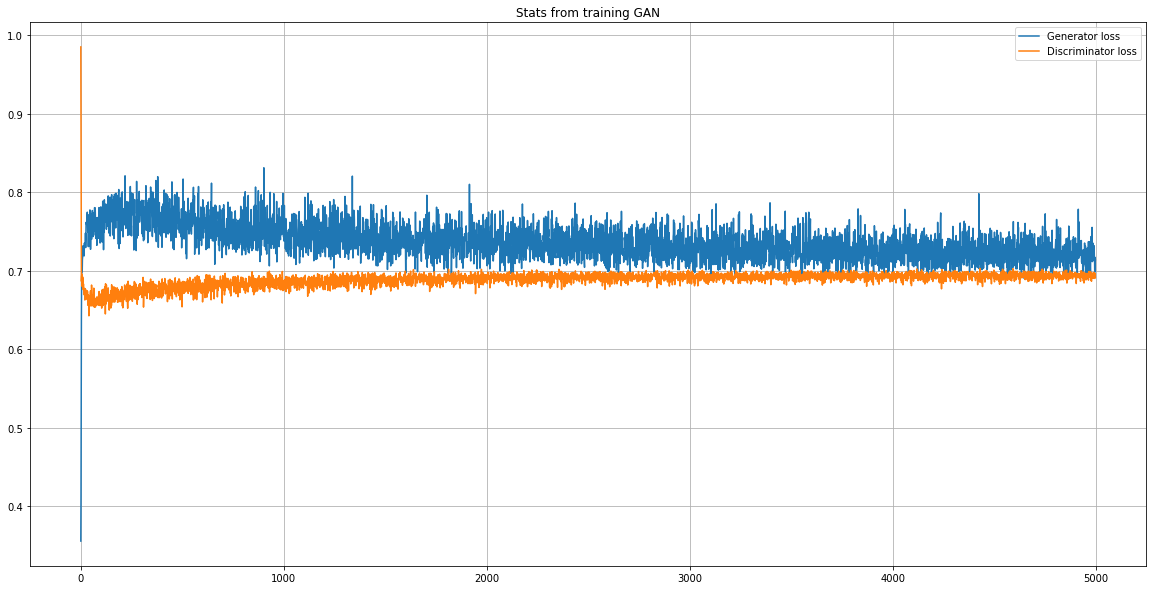

In [0]:
train(gan3, generator3, discriminator3, gender_ohe.values, latent_dim, n_epochs = 5000, n_batch = 256, n_eval = 250) #GAN training

###Generating homogeneous categorical data with generator 

In [0]:
noise = np.random.normal(0, 1, (10000, 100))
generated_categorical_data2 = generator3.predict(noise)
generated_categorical_data2

array([[1.0000000e+00, 8.0513279e-10],
       [9.9999332e-01, 6.6958833e-06],
       [1.4125016e-10, 1.0000000e+00],
       ...,
       [2.1017400e-11, 1.0000000e+00],
       [1.0000000e+00, 1.5108084e-12],
       [1.0000000e+00, 3.3435496e-19]], dtype=float32)

### Generated data to same form as original data

In [0]:
gen_df3 = pd.DataFrame(data = np.round(generated_categorical_data2), columns = gender_ohe.columns)
gen_df3

,Gender_Female,Gender_Male
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
9995,0.0,1.0
9996,1.0,0.0
9997,0.0,1.0
9998,1.0,0.0


#### Comapring generated and original data
 * Count generated and original ohe values

In [0]:
#original data value count
for column in gen_df3.columns:
    print(gender_ohe[column].value_counts())

1    5000
0    5000
Name: Gender_Female, dtype: int64
1    5000
0    5000
Name: Gender_Male, dtype: int64


In [0]:
#generated data value count
for column in gen_df3.columns:
    print(gen_df3[column].value_counts())

0.0    5018
1.0    4982
Name: Gender_Female, dtype: int64
1.0    5018
0.0    4982
Name: Gender_Male, dtype: int64


# *Results*
 * A heterogeneous data will cause problems if the amount of some variable is too small for the size of the dataset. The generator does not generate this small amount of data at all (bmi_class_underweight 42pcs out of 10000)
 * Generated homogenous data is very similar compared to the original (under 1% error of generating same amount of categorical ohe varaibles)

--------------------------------------------------------------------------------

# Generating categorical and numerical data with GAN

#### Generator
 * Generator takes input from the random normal distribution (latent_dim)
 * Generator handles numerical and ohe values in different branches
 * Combine different branch outputs as one output (generator output)

In [0]:
def build_generator(categorical_data_shape, categorical_data_shape2, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating categorical gender data
    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)

    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)
    #Output 1 layer, softmax activation for multi classification
    branch_1_output = Dense(categorical_data_shape, activation = "softmax")(branch_1)

    #Branch 2 for generating categorical bmi_class data
    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)

    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    #Output 2 layer, softmax activation for multi classification
    branch_2_output = Dense(categorical_data_shape2, activation = "softmax")(branch_2)

    #Branch 3 for generating numerical data
    branch_3 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)

    branch_3 = Dense(128, kernel_initializer = "he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    #Output 3, sigmoid activation
    branch_3_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_3_hidden_2)

    #Combined output
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output])
    #Return model
    return Model(inputs = noise, outputs = combined_output)

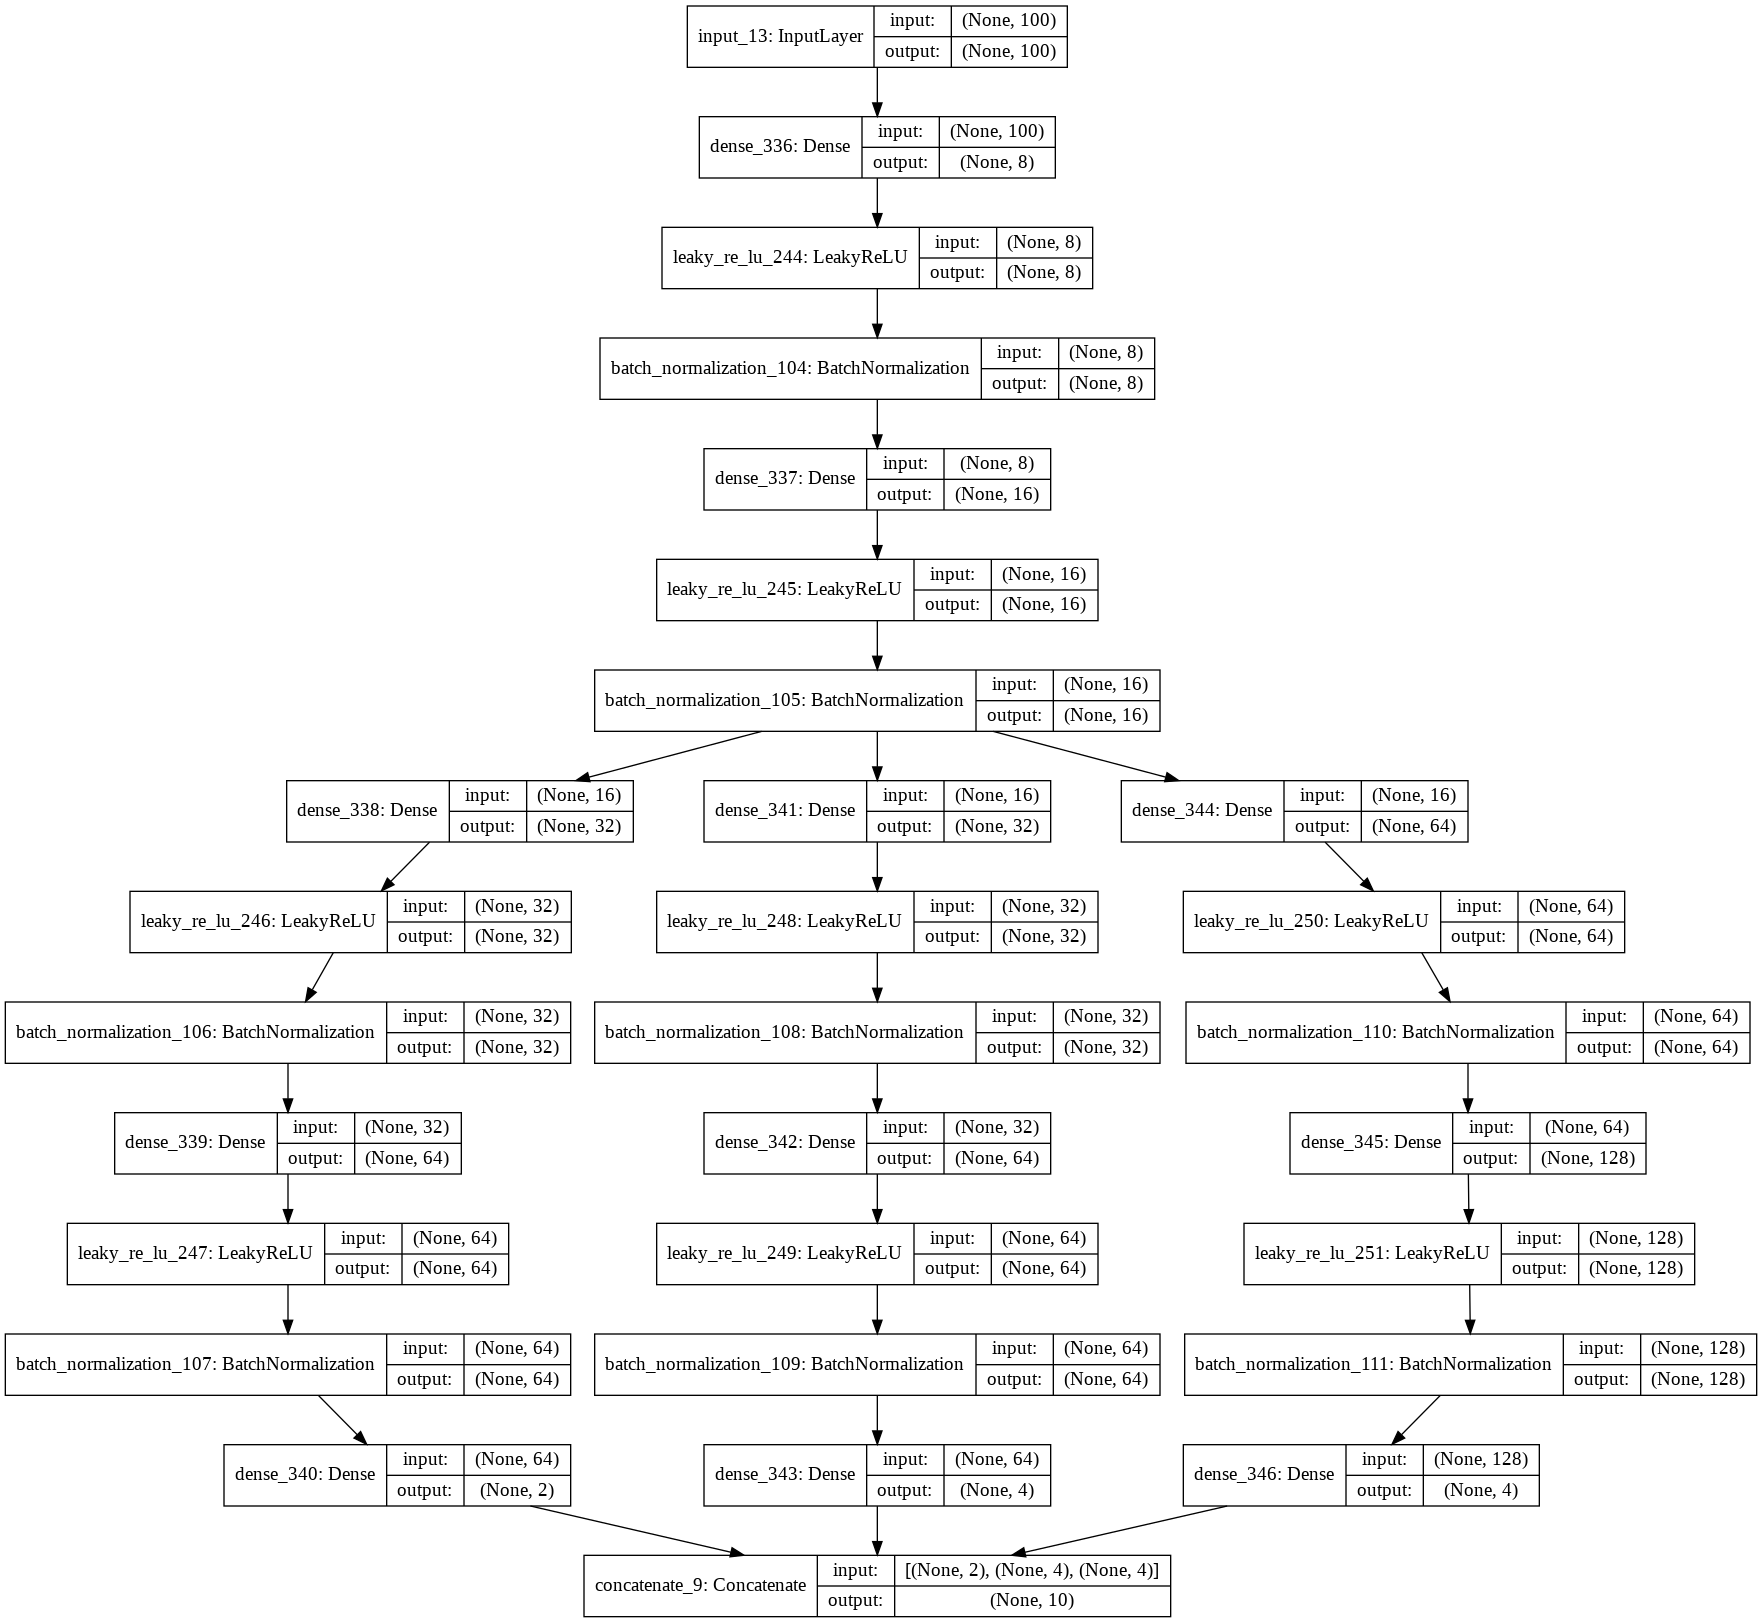

In [0]:
generator4 = build_generator(gender_ohe.shape[1], bmi_class_ohe.shape[1], numerical_data_rescaled.shape[1])
plot_model(generator4, show_layer_names = True, show_shapes = True)

#### Discriminator
 * Input is size of the data
 * Outputs classification

In [0]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [0]:
inputs_n = gender_ohe.shape[1] + bmi_class_ohe.shape[1] + numerical_data_rescaled.shape[1]
inputs_n

10

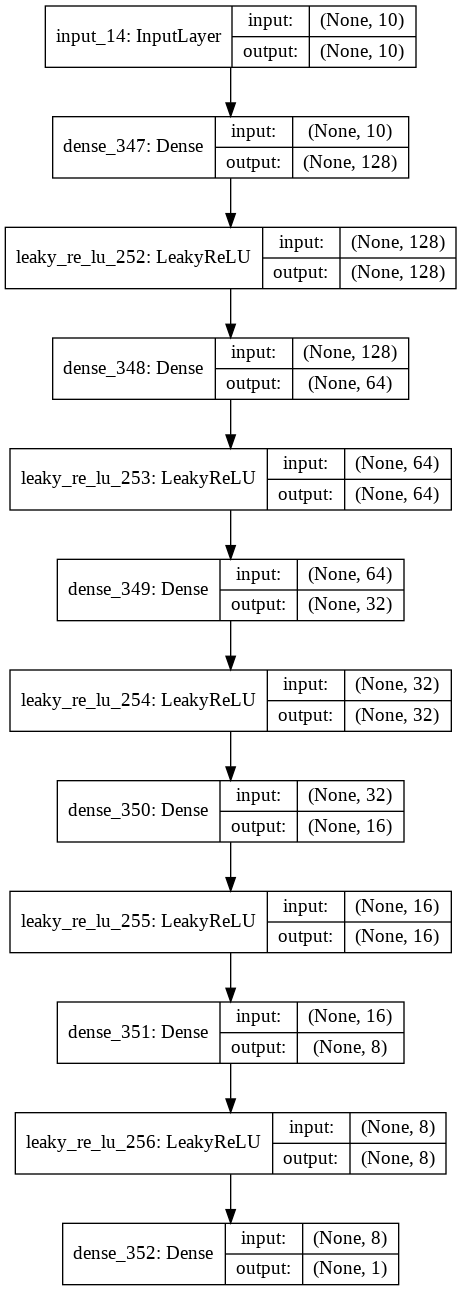

In [0]:
discriminator4 = build_discriminator(inputs_n)
plot_model(discriminator4, show_layer_names = True, show_shapes = True)

#### GAN
 * GAN input is generator input
 * GAN output is discriminator output

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

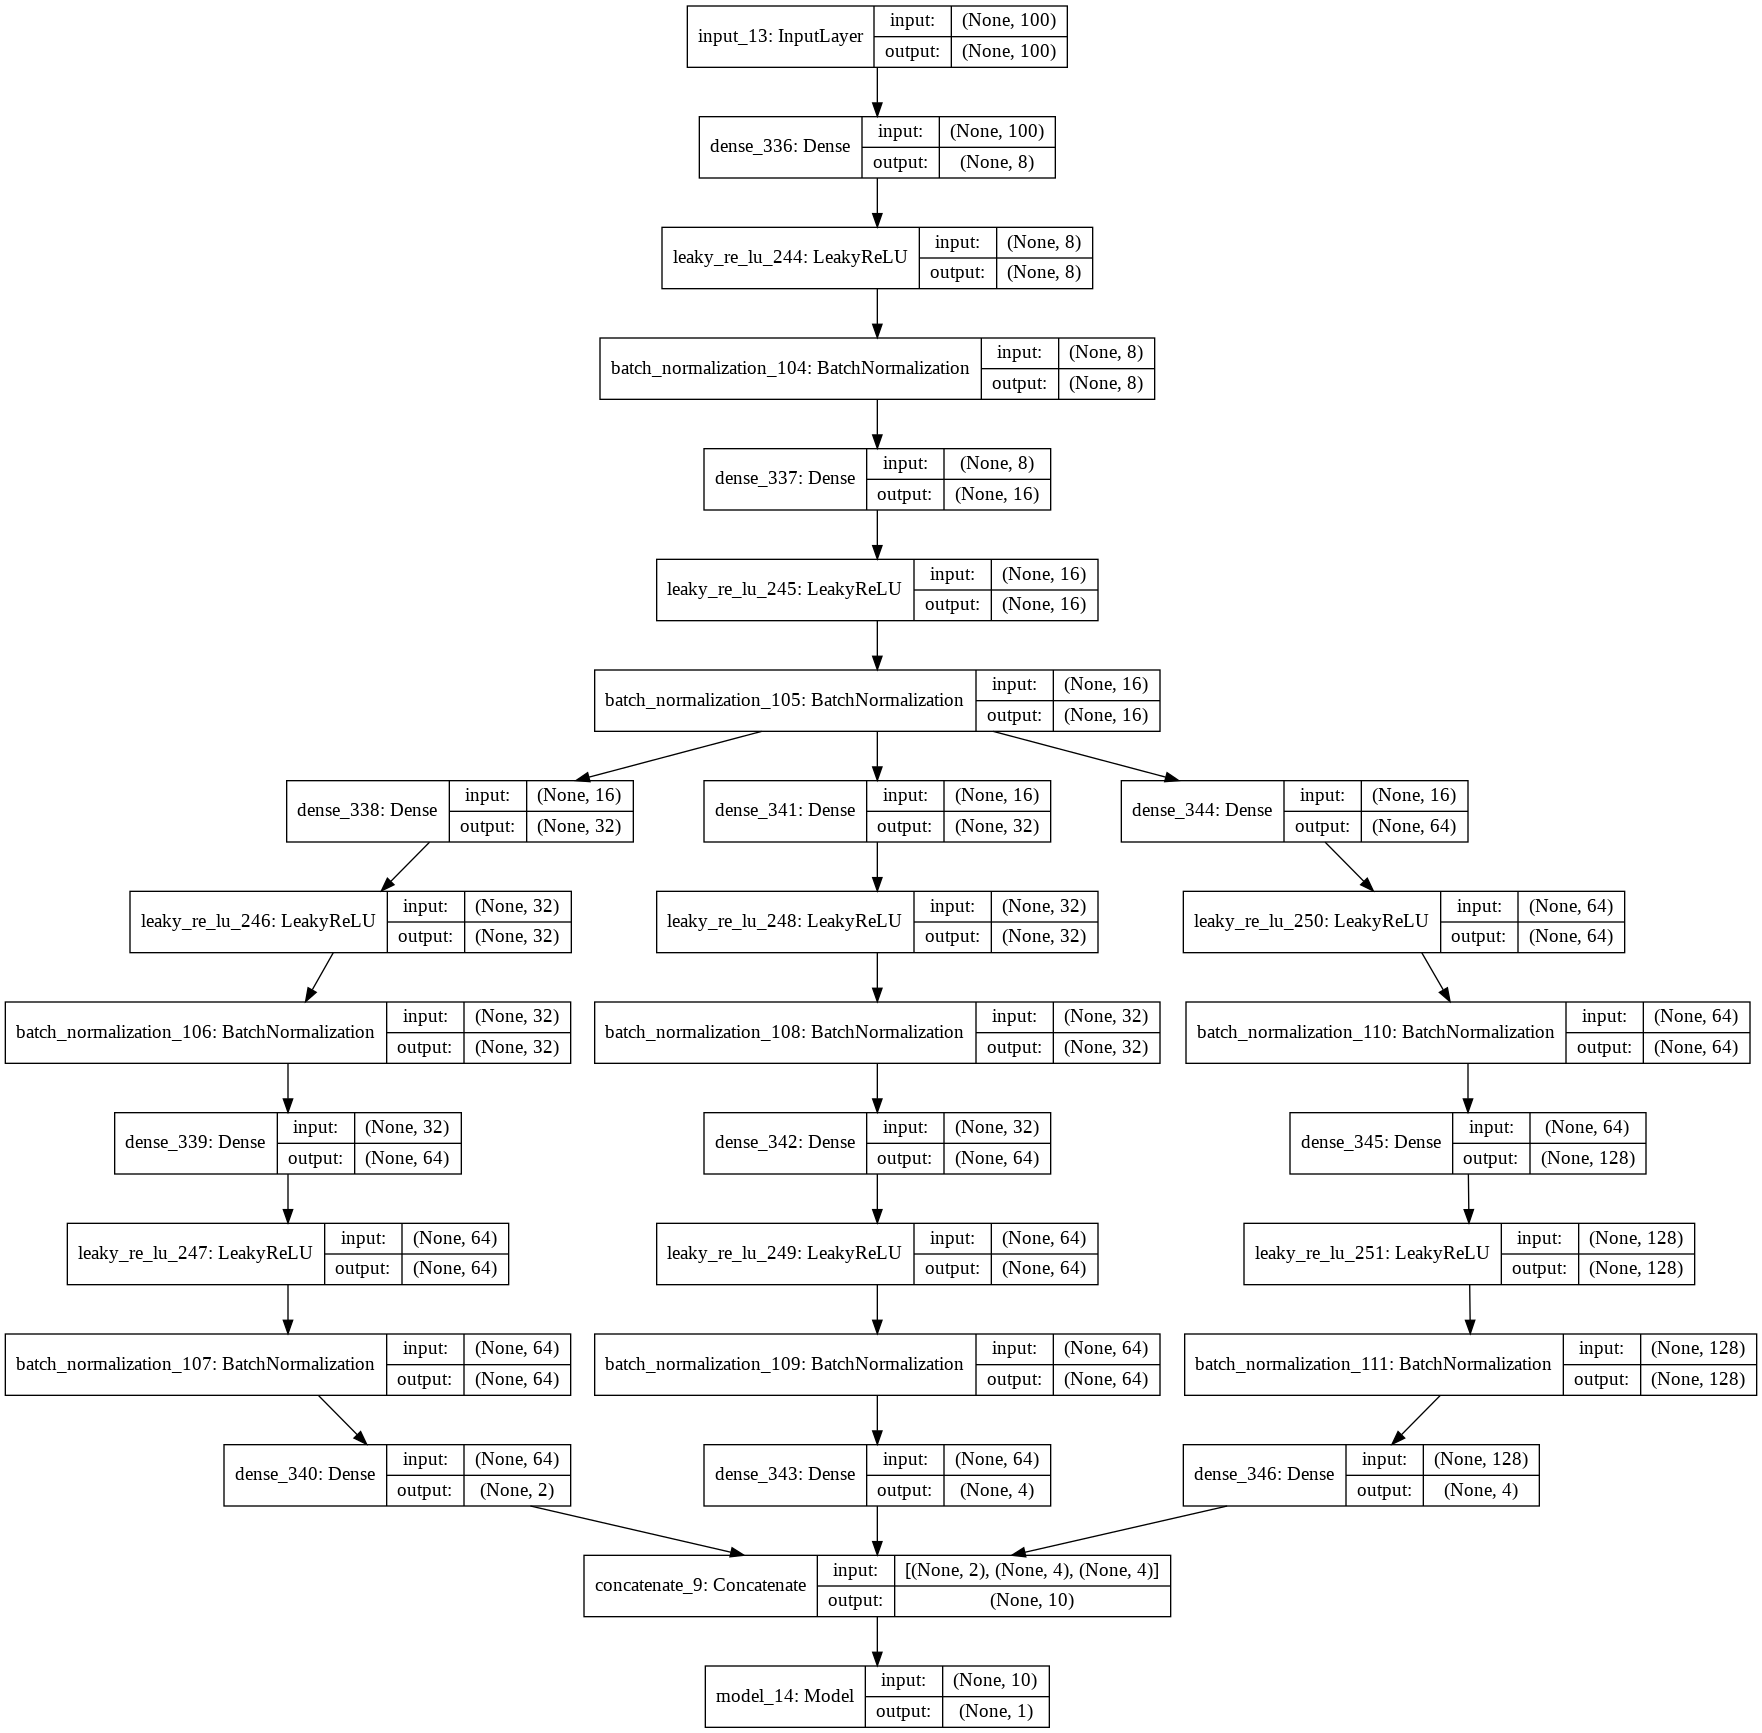

In [0]:
gan4 = build_gan(generator4, discriminator4)
plot_model(gan4, show_layer_names = True, show_shapes = True)

#### GAN training

In [0]:
def train(gan, generator, discriminator, categorical_data, categorical_data2, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []

    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):

        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        gender_real = categorical_data[idx]
        bmi_real = categorical_data2[idx]
        numerical_real = numerical_data[idx]
        
        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([gender_real, bmi_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
    
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

Epoch: 200 [Discriminator loss: 0.687793] [Generator loss: 0.679744]
Epoch: 400 [Discriminator loss: 0.686592] [Generator loss: 0.686811]
Epoch: 600 [Discriminator loss: 0.682664] [Generator loss: 0.692192]
Epoch: 800 [Discriminator loss: 0.686256] [Generator loss: 0.696813]
Epoch: 1000 [Discriminator loss: 0.687463] [Generator loss: 0.700255]
Epoch: 1200 [Discriminator loss: 0.690072] [Generator loss: 0.706654]
Epoch: 1400 [Discriminator loss: 0.688019] [Generator loss: 0.703223]
Epoch: 1600 [Discriminator loss: 0.691656] [Generator loss: 0.701813]
Epoch: 1800 [Discriminator loss: 0.690267] [Generator loss: 0.700814]
Epoch: 2000 [Discriminator loss: 0.690937] [Generator loss: 0.706095]
Epoch: 2200 [Discriminator loss: 0.690022] [Generator loss: 0.700005]


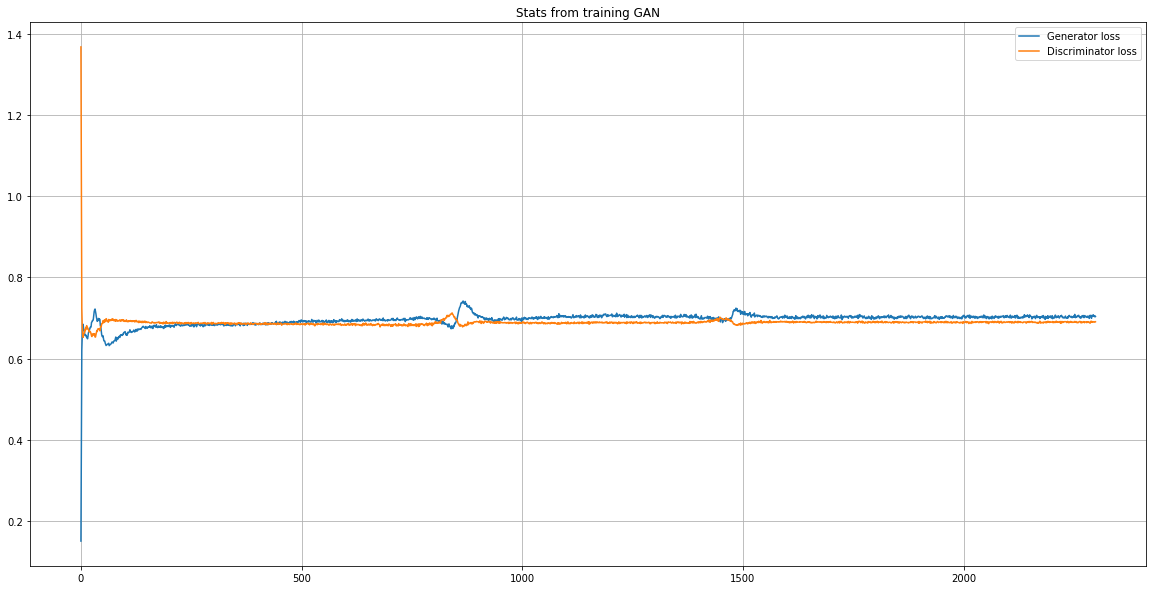

In [0]:
latent_dim = 100
train(gan4, generator4, discriminator4, gender_ohe.values, bmi_class_ohe.values, numerical_data_rescaled, latent_dim, n_epochs = 2300, n_batch = 2048, n_eval = 200)

### Generating categorical and numerical data with generator

In [0]:
noise = np.random.normal(0, 1, (10000, 100))
generated_mixed_data = generator4.predict(noise)
generated_mixed_data

array([[6.5177805e-09, 1.0000000e+00, 6.0876209e-01, ..., 6.1912340e-01,
        4.9177581e-01, 4.8557207e-01],
       [1.0913557e-24, 1.0000000e+00, 2.1655799e-18, ..., 5.6651312e-01,
        5.7311296e-01, 6.5712827e-01],
       [9.9999976e-01, 2.4986926e-07, 9.9999988e-01, ..., 3.1343400e-01,
        2.6918650e-01, 3.7169328e-01],
       ...,
       [1.0000000e+00, 8.3462080e-22, 1.0000000e+00, ..., 4.2388344e-01,
        3.3199945e-01, 4.4132009e-01],
       [1.1695668e-26, 1.0000000e+00, 3.8878457e-18, ..., 5.2725494e-01,
        5.7334667e-01, 7.0970201e-01],
       [2.0165229e-10, 1.0000000e+00, 3.3639376e-03, ..., 5.7177657e-01,
        4.4709170e-01, 4.0972564e-01]], dtype=float32)

### Generated data to same form as original data

In [0]:
columns = list(gender_ohe.columns) + list(bmi_class_ohe.columns) + list(numerical_data.columns)
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df

,Gender_Female,Gender_Male,bmi_class_healthy,bmi_class_overweight,bmi_class_severely overweight,bmi_class_underweight,patient_id,Height,Weight,bmi
0,6.517781e-09,1.000000e+00,6.087621e-01,3.890011e-01,9.748723e-04,1.261859e-03,0.071617,0.619123,0.491776,0.485572
1,1.091356e-24,1.000000e+00,2.165580e-18,1.000000e+00,6.474741e-11,4.974434e-10,0.307223,0.566513,0.573113,0.657128
2,9.999998e-01,2.498693e-07,9.999999e-01,1.527332e-16,1.202344e-07,3.369300e-10,0.103941,0.313434,0.269186,0.371693
3,6.787892e-18,1.000000e+00,2.128410e-22,1.000000e+00,1.516234e-11,3.028638e-10,0.339649,0.560647,0.526781,0.678552
4,1.000000e+00,2.398346e-21,1.000000e+00,1.086912e-20,2.371742e-11,6.409379e-13,0.479014,0.392338,0.355794,0.455573
...,...,...,...,...,...,...,...,...,...,...
9995,2.125468e-26,1.000000e+00,1.175566e-16,9.999919e-01,8.116408e-06,1.372956e-08,0.453946,0.588410,0.600515,0.737494
9996,4.573263e-27,1.000000e+00,7.991927e-19,1.000000e+00,6.310014e-12,7.932580e-11,0.535188,0.537637,0.568309,0.708580
9997,1.000000e+00,8.346208e-22,1.000000e+00,4.392768e-26,2.227189e-13,2.262947e-14,0.975042,0.423883,0.331999,0.441320
9998,1.169567e-26,1.000000e+00,3.887846e-18,1.000000e+00,1.949073e-09,2.635000e-08,0.888659,0.527255,0.573347,0.709702


In [0]:
mixed_gen_df.iloc[:, 0:6] = np.round(mixed_gen_df.iloc[:, 0:6])
mixed_gen_df.iloc[:, 6:10] = mms.inverse_transform(mixed_gen_df.iloc[:, 6:10])
mixed_gen_df

,Gender_Female,Gender_Male,bmi_class_healthy,bmi_class_overweight,bmi_class_severely overweight,bmi_class_underweight,patient_id,Height,Weight,bmi
0,0.0,1.0,1.0,0.0,0.0,0.0,7163.304199,1.767269,75.140556,23.986357
1,0.0,1.0,0.0,1.0,0.0,0.0,30719.494141,1.734215,82.714493,27.002316
2,1.0,0.0,1.0,0.0,0.0,0.0,10395.106445,1.575209,54.413532,21.984367
3,0.0,1.0,0.0,1.0,0.0,0.0,33961.496094,1.730529,78.400139,27.378950
4,1.0,0.0,1.0,0.0,0.0,0.0,47895.281250,1.624784,62.478241,23.458973
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,0.0,1.0,0.0,0.0,45388.976562,1.747972,85.266068,28.415142
9996,0.0,1.0,0.0,1.0,0.0,0.0,53511.605469,1.716073,82.267143,27.906832
9997,1.0,0.0,1.0,0.0,0.0,0.0,97488.703125,1.644603,60.262535,23.208406
9998,0.0,1.0,0.0,1.0,0.0,0.0,88852.062500,1.709550,82.736252,27.926561


In [0]:
#original data
og_data = pd.concat([gender_ohe, bmi_class_ohe, numerical_data], axis = 1)
og_data

,Gender_Female,Gender_Male,bmi_class_healthy,bmi_class_overweight,bmi_class_severely overweight,bmi_class_underweight,patient_id,Height,Weight,bmi
0,0,1,0,0,1,0,90329,1.875714,109.721075,31.19
1,0,1,1,0,0,0,82793,1.747060,73.622792,24.12
2,0,1,0,1,0,0,98691,1.882397,96.497629,27.23
3,0,1,0,0,1,0,20430,1.821967,99.809586,30.07
4,0,1,0,1,0,0,96554,1.774998,93.598695,29.71
...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,0,0,0,51506,1.680785,62.041210,21.96
9996,1,0,0,1,0,0,38900,1.703506,77.504378,26.71
9997,1,0,1,0,0,0,26718,1.622247,58.275424,22.14
9998,1,0,1,0,0,0,67447,1.753470,74.322226,24.17


### Comparing original and generated data
 * normal distribution, mean, std, var
 * correlation matrix
 * counting categorical ohe variables
 * neural network classifier

Gender_Female Normal distribution


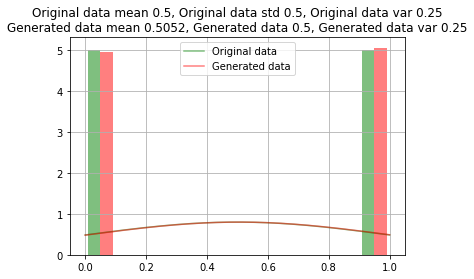

Gender_Male Normal distribution


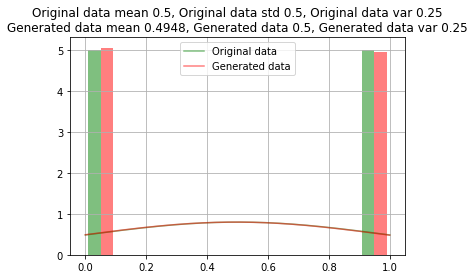

bmi_class_healthy Normal distribution


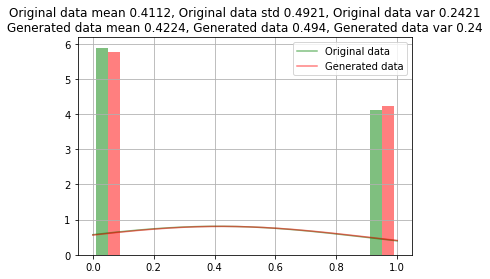

bmi_class_overweight Normal distribution


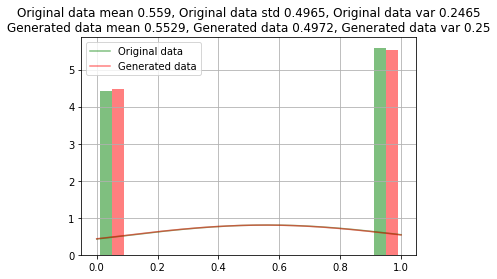

bmi_class_severely overweight Normal distribution


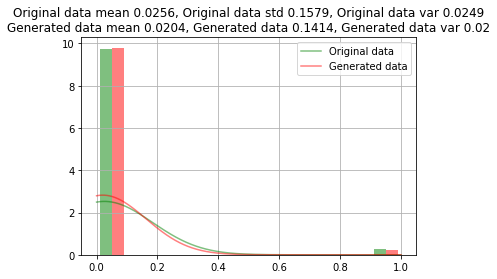

bmi_class_underweight Normal distribution


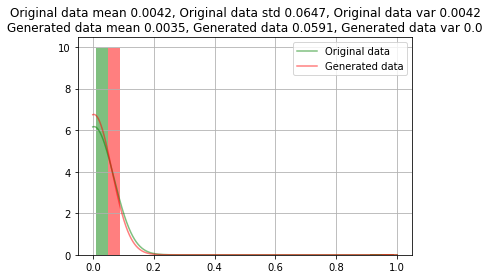

patient_id Normal distribution


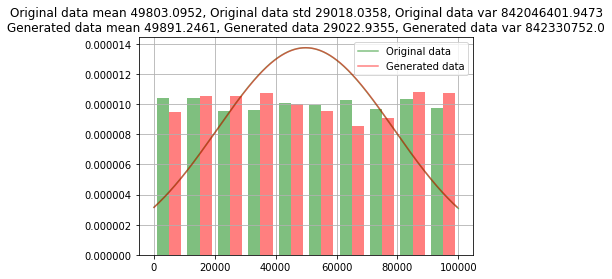

Height Normal distribution


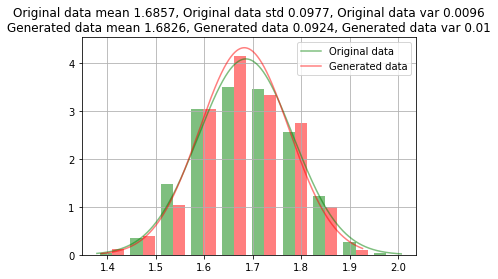

Weight Normal distribution


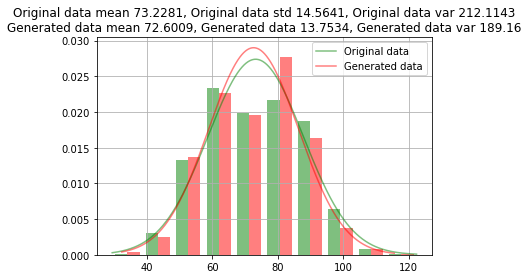

bmi Normal distribution


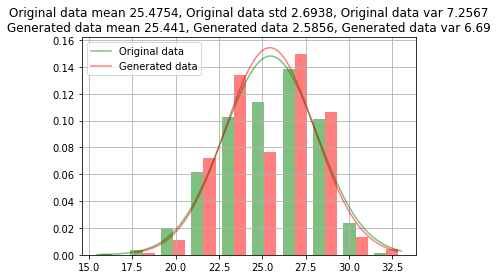

In [0]:
for column in mixed_gen_df.columns:
    print(column, "Normal distribution")
    normal_distribution(og_data[column], mixed_gen_df[column])

correlation matrix

Original data


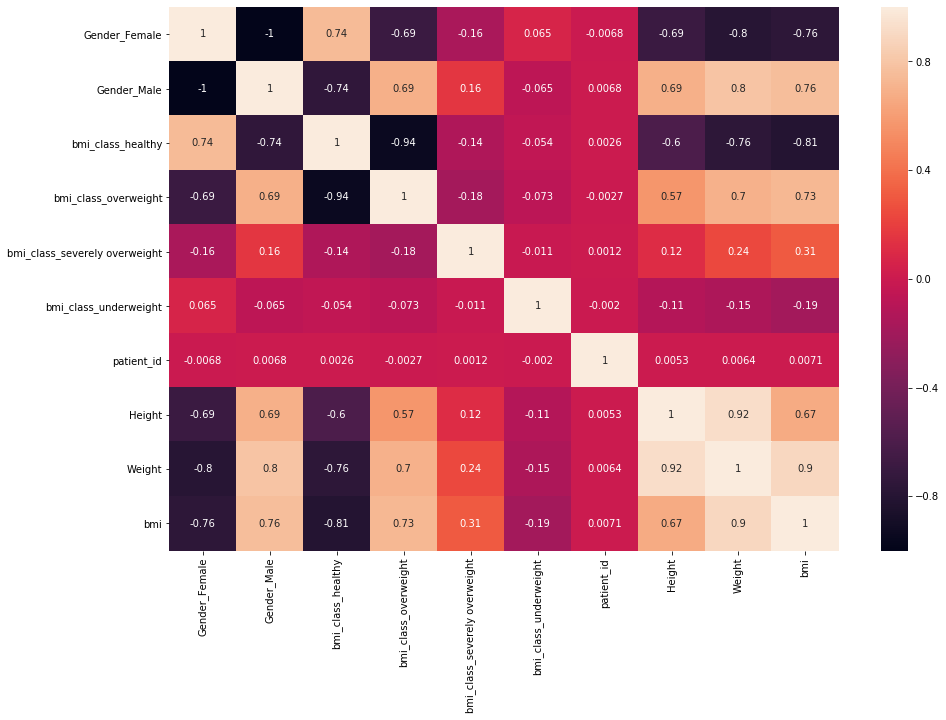

In [0]:
#correlation matrix compareing
print("Original data")
plt.figure(figsize = (15, 10))
sns.heatmap(og_data.corr(), annot = True)

Generated data


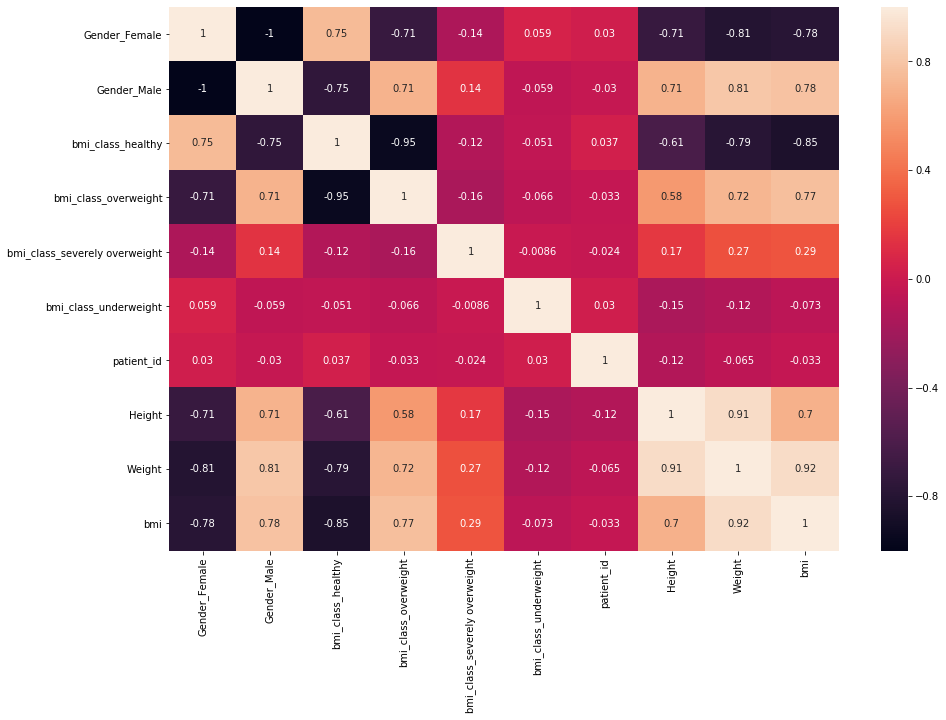

In [0]:
print("Generated data")
plt.figure(figsize = (15, 10))
sns.heatmap(mixed_gen_df.corr(), annot = True)

counting categorical variables

In [0]:
#original data value count
for column in og_data.iloc[:, 0:6].columns:
    print(og_data[column].value_counts())

1    5000
0    5000
Name: Gender_Female, dtype: int64
1    5000
0    5000
Name: Gender_Male, dtype: int64
0    5888
1    4112
Name: bmi_class_healthy, dtype: int64
1    5590
0    4410
Name: bmi_class_overweight, dtype: int64
0    9744
1     256
Name: bmi_class_severely overweight, dtype: int64
0    9958
1      42
Name: bmi_class_underweight, dtype: int64


In [0]:
#generated data value count
for column in og_data.iloc[:, 0:6].columns:
    print(mixed_gen_df[column].value_counts())

1.0    5052
0.0    4948
Name: Gender_Female, dtype: int64
0.0    5052
1.0    4948
Name: Gender_Male, dtype: int64
0.0    5776
1.0    4224
Name: bmi_class_healthy, dtype: int64
1.0    5529
0.0    4471
Name: bmi_class_overweight, dtype: int64
0.0    9796
1.0     204
Name: bmi_class_severely overweight, dtype: int64
0.0    9965
1.0      35
Name: bmi_class_underweight, dtype: int64


neural network classifier
 * classification based on gender

In [0]:
def classifier():
    model = Sequential()
    model.add(Dense(128, activation = "relu", input_dim = 3))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

def classifier_train(classifier, x_train, y_train, epoch_limit=100, batch_size=256):
        
    history = classifier.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_limit, verbose=0)

def evaluate(classifier, x_test, y_test):
    score = classifier.evaluate(x_test, y_test, verbose=1)
    print("Test Loss = {}, Test Accuracy = {}".format(score[0], score[1]))

original data

In [0]:
le = LabelEncoder()
gender_labels = le.fit_transform(df.Gender)
gender_labels

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
from sklearn.model_selection import train_test_split

X = og_data.iloc[:, 7:] #features
y = gender_labels #target labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [0]:
model = classifier()
classifier_train(model, x_train, y_train)
evaluate(model, x_test, y_test)

1000/1000 [==============================] - 4s 4ms/step
Test Loss = 0.22275649595260621, Test Accuracy = 0.915


generated data

In [0]:
# generated data target labels
gen_dummies = mixed_gen_df.iloc[:, :2]
s = pd.DataFrame(gen_dummies.columns[np.where(gen_dummies != 0)[1]], columns = ["Gender"])
s

,Gender
0,Gender_Male
1,Gender_Male
2,Gender_Female
3,Gender_Male
4,Gender_Female
...,...
9995,Gender_Male
9996,Gender_Male
9997,Gender_Female
9998,Gender_Male


In [0]:
y = le.fit_transform(s)
y

array([1, 1, 0, ..., 0, 1, 1])

In [0]:
X = mixed_gen_df.iloc[:, 7:] #features
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [0]:
model = classifier()
classifier_train(model, x_train, y_train)
evaluate(model, x_test, y_test)

1000/1000 [==============================] - 4s 4ms/step
Test Loss = 0.18720565822720528, Test Accuracy = 0.916


# *Results*
### Categorical data
 * Heterogeneous data, relatively similar except for a small number (0.005% of data set) of underweight class variables that are not generated at all by the generator (same problem as previus example)
 * Homogeneous data similar to original about 1% error in number of categorical variables generated

### Numerical data
 * Numerical data similar compared to original

### Neural network classifier
 * On average, the generated data is as good as, or even better, in the classification than the original data

--------------------------------------------------------------------------------

# Conditional GAN
* In conditional GAN you can generate data rows based on the label
* trying to solve heterogenous data problem and generating "events" based on the "patient" atributes

In [0]:
event17_ohe = pd.get_dummies(df["2017"])
event18_ohe = pd.get_dummies(df["2018"])
event19_ohe = pd.get_dummies(df["2019"])
event20_ohe = pd.get_dummies(df["2020"])
bmi_ohe = pd.get_dummies(df["bmi_class"])
gender_ohe = pd.get_dummies(df.Gender)

event17_ohe

,ei jatkotoimenpiteita,laakarikaynti 1,laakarikaynti 2,laakarikaynti 3,laakarikaynti 4
0,0,0,1,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
9995,1,0,0,0,0
9996,0,0,0,1,0
9997,1,0,0,0,0
9998,1,0,0,0,0


In [0]:
le = LabelEncoder()
labels = le.fit_transform(df.bmi_class).reshape(-1, 1)
labels

array([[2],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [0]:
numerical_data = df.select_dtypes("number")

In [0]:
mms = MinMaxScaler()
numerical_data_rescaled = mms.fit_transform(numerical_data)
numerical_data_rescaled

array([[0.90343165, 0.79172838, 0.863139  , 0.89533561],
       [0.82805733, 0.58695829, 0.4754764 , 0.49317406],
       [0.98706754, 0.8023644 , 0.72113127, 0.67007964],
       ...,
       [0.26720077, 0.38830089, 0.31065968, 0.38054608],
       [0.67456817, 0.59715974, 0.48298768, 0.4960182 ],
       [0.70073314, 0.31052854, 0.23843869, 0.30546075]])

In [0]:
print("event2017 ohe shape:", event17_ohe.shape)
print("event2018 ohe shape:", event18_ohe.shape)
print("event2019 ohe shape:", event19_ohe.shape)
print("event2020 ohe shape:", event20_ohe.shape)
print("gender ohe shape:", gender_ohe.shape)
print("numerical data shape:", numerical_data_rescaled.shape)

event2017 ohe shape: (10000, 5)
event2018 ohe shape: (10000, 5)
event2019 ohe shape: (10000, 5)
event2020 ohe shape: (10000, 5)
gender ohe shape: (10000, 2)
numerical data shape: (10000, 4)


#### Generaattori
 * Generator takes random input from the normal distribution and labels
 * Generator function parameters are the size of the columns we want to generate

In [0]:
def build_generator(ohe1, ohe2, ohe3, ohe4, ohe5, numerical):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    noise_branch = Dense(4)(noise)

    #label input
    label_input = Input(shape = (1,))
    label_branch = Dense(2)(label_input)
    
    #combine input branches
    merge = concatenate([noise_branch, label_branch])

    hidden_1 = Dense(4)(merge)
    hidden_1 = LeakyReLU(alpha=0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(8)(hidden_1)
    hidden_2 = LeakyReLU(alpha=0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating ohe1 data
    branch_1 = Dense(16)(hidden_2)
    branch_1 = LeakyReLU(alpha=0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)
    branch_1 = Dense(8)(branch_1)
    branch_1 = LeakyReLU(alpha=0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)
    #Output 1, sofmax activation
    branch_1_output = Dense(ohe1, activation = "softmax")(branch_1)

    #Branch 2 for generating ohe2 data
    branch_2 = Dense(16)(hidden_2)
    branch_2 = LeakyReLU(alpha=0.2)(branch_2)
    branch_2 = BatchNormalization(momentum = 0.8)(branch_2)
    branch_2 = Dense(8)(branch_2)
    branch_2 = LeakyReLU(alpha=0.2)(branch_2)
    branch_2 = BatchNormalization(momentum = 0.8)(branch_2)
    #Output 2, sofmax activation
    branch_2_output = Dense(ohe2, activation = "softmax")(branch_2)

    #Branch 3 for generating ohe3
    branch_3 = Dense(16)(hidden_2)
    branch_3 = LeakyReLU(alpha=0.2)(branch_3)
    branch_3 = BatchNormalization(momentum = 0.8)(branch_3)
    branch_3 = Dense(8)(branch_3)
    branch_3 = LeakyReLU(alpha=0.2)(branch_3)
    #Output 3, softmax activation
    branch_3 = BatchNormalization(momentum = 0.8)(branch_3)
    branch_3_output = Dense(ohe3, activation = "softmax")(branch_3)

    #Branch 4 for generating ohe4
    branch_4 = Dense(16)(hidden_2)
    branch_4 = LeakyReLU(alpha=0.2)(branch_4)
    branch_4 = BatchNormalization(momentum = 0.8)(branch_4)
    branch_4 = Dense(8)(branch_4)
    branch_4 = LeakyReLU(alpha=0.2)(branch_4)
    branch_4 = BatchNormalization(momentum = 0.8)(branch_4)
    #Output 4, sofmax activation
    branch_4_output = Dense(ohe4, activation = "softmax")(branch_4)

    #Branch 5 for generating bmi ohe
    branch_5 = Dense(16)(hidden_2)
    branch_5 = LeakyReLU(alpha=0.2)(branch_5)
    branch_5 = BatchNormalization(momentum = 0.8)(branch_5)
    branch_5 = Dense(8)(branch_5)
    branch_5 = LeakyReLU(alpha=0.2)(branch_5)
    branch_5 = BatchNormalization(momentum = 0.8)(branch_5)
    #Output 4, sofmax activation
    branch_5_output = Dense(ohe5, activation = "softmax")(branch_5)

    #Branch 6 for generating numerical data
    branch_6 = Dense(16)(hidden_2)
    branch_6 = LeakyReLU(alpha=0.2)(branch_6)
    branch_6 = BatchNormalization(momentum = 0.8)(branch_6)
    branch_6 = Dense(8)(branch_6)
    branch_6 = LeakyReLU(alpha=0.2)(branch_6)
    branch_6 = BatchNormalization(momentum = 0.8)(branch_6)
    #Output 4, sofmax activation
    branch_6_output = Dense(numerical, activation = "sigmoid")(branch_6)

    #Combined generator output branch_1_output, branch_2_output, branch_3_output, branch_4_output, 
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output, branch_4_output, branch_5_output, branch_6_output], axis = 1)
    #Return model
    model = Model(inputs = [noise, label_input], outputs = combined_output)
    return model

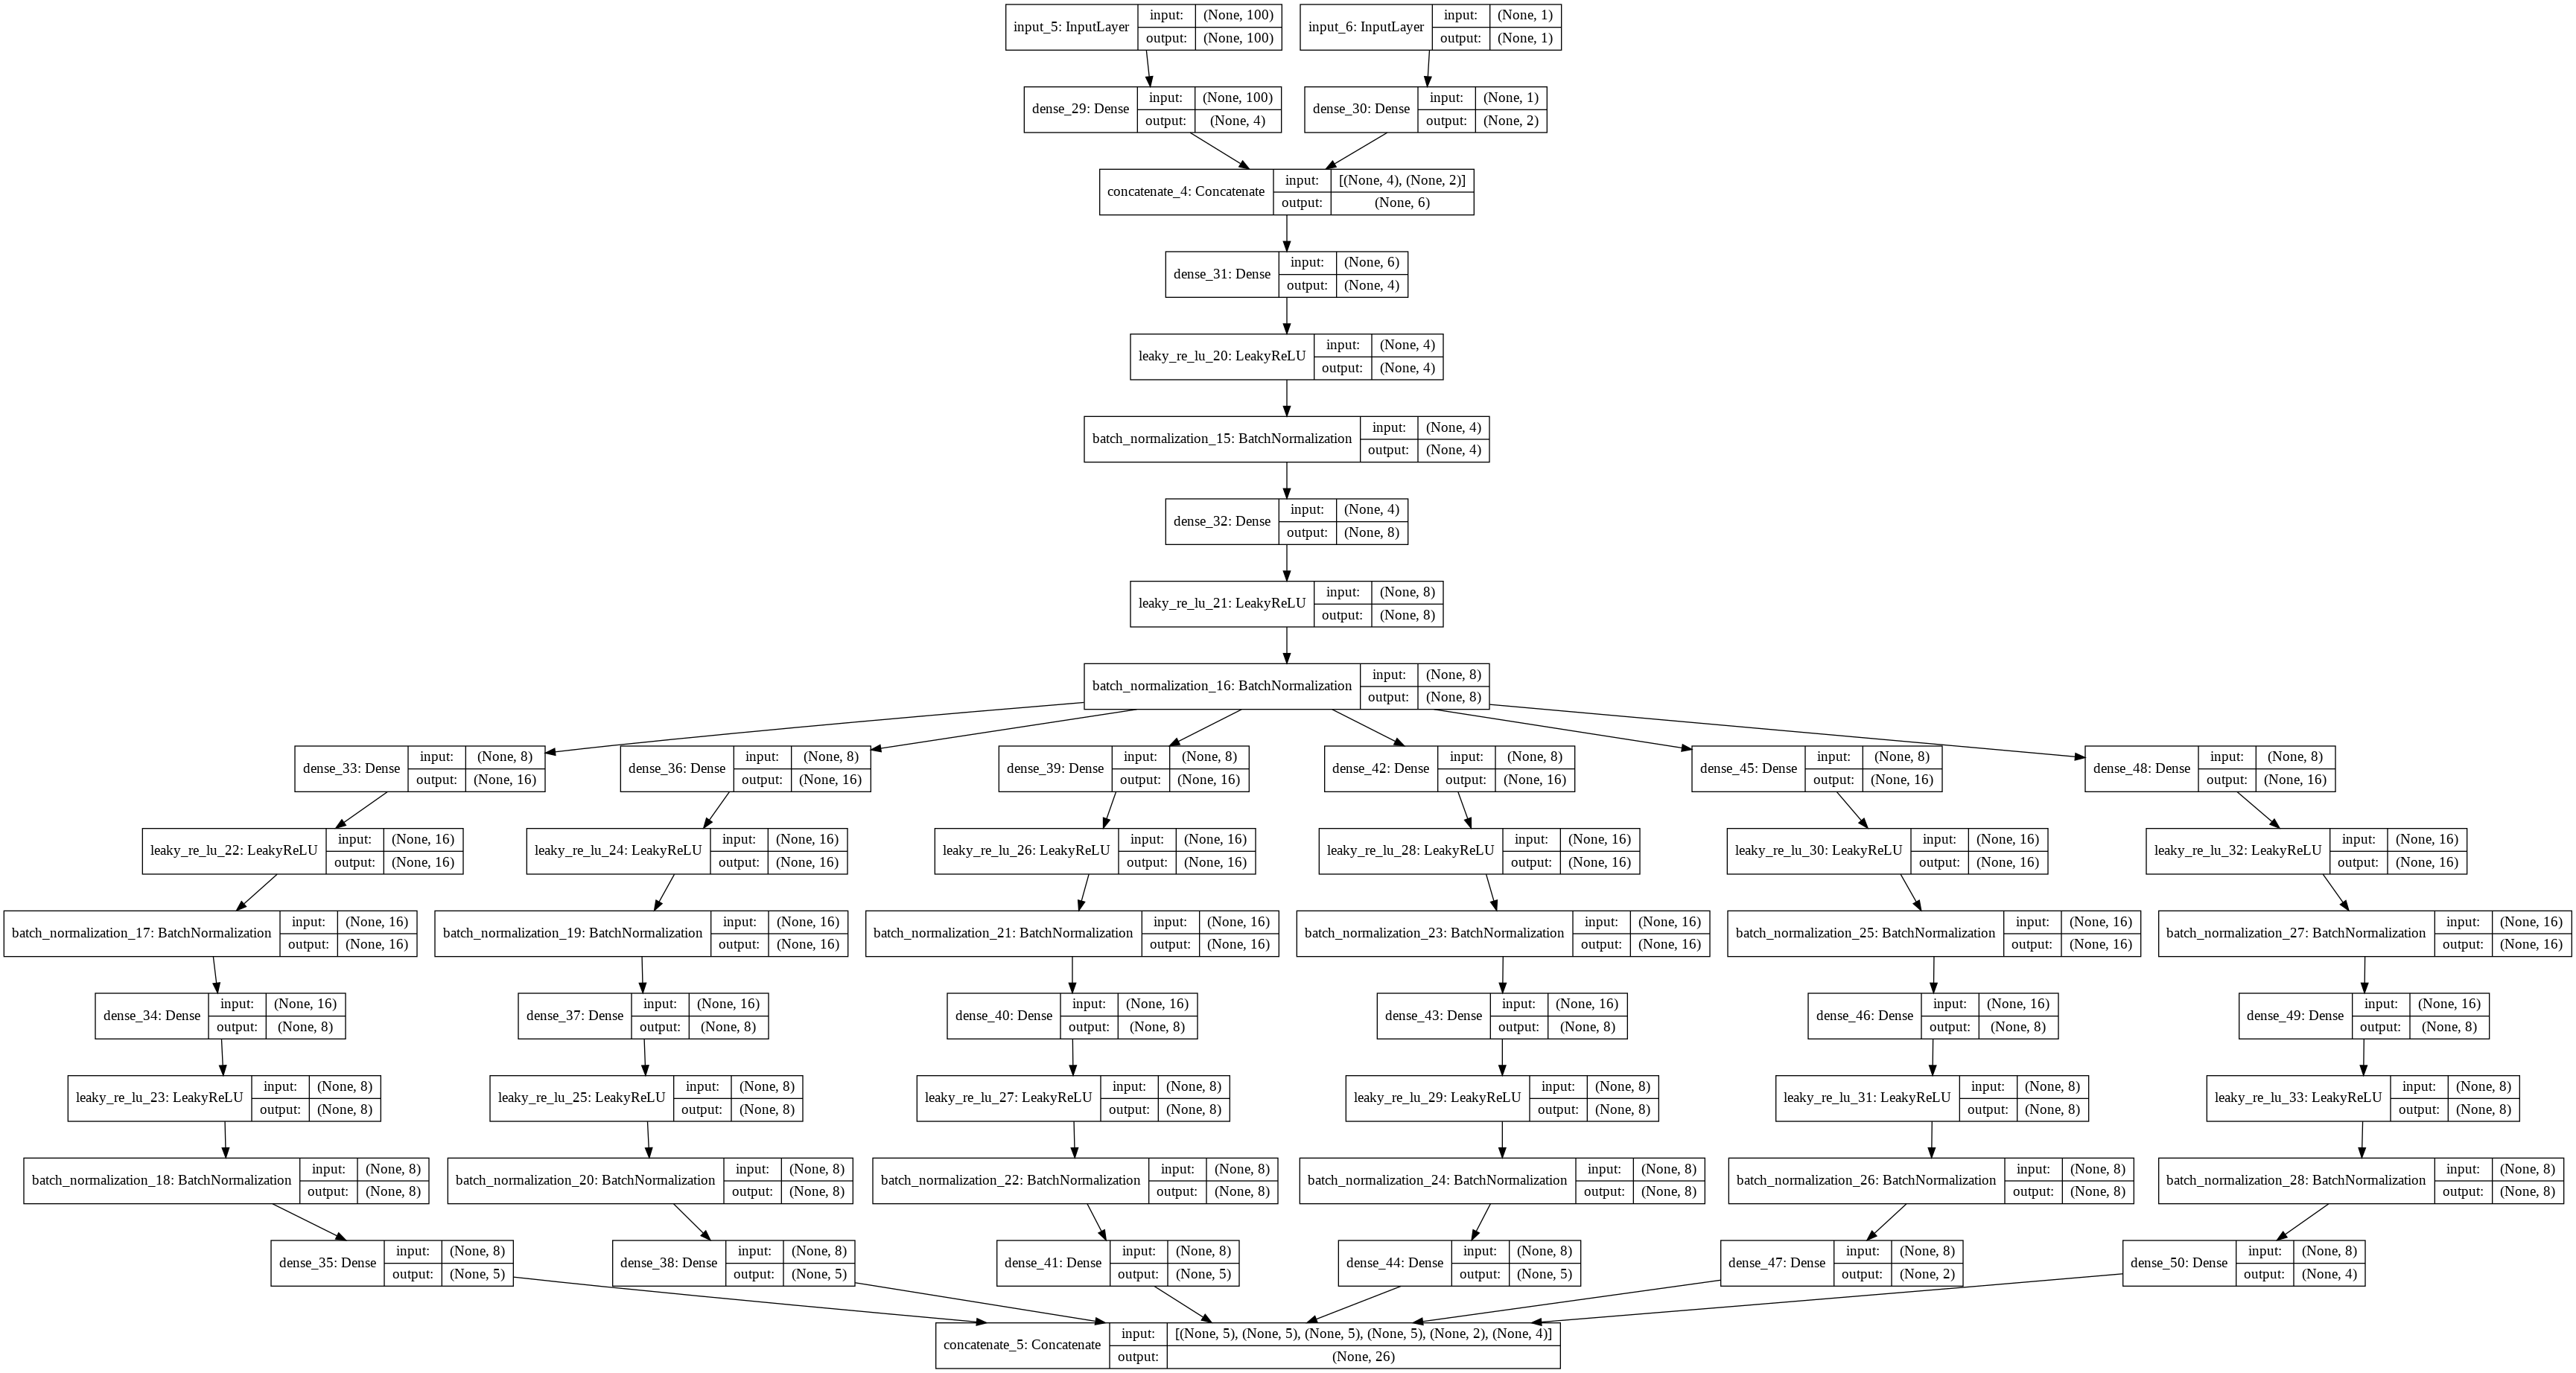

In [0]:
generator5 = build_generator(event17_ohe.shape[1], event18_ohe.shape[1], event19_ohe.shape[1], event20_ohe.shape[1], gender_ohe.shape[1], numerical_data_rescaled.shape[1]) #Initialize generator
plot_model(generator5, show_layer_names = True, show_shapes = True)#Plot generator

#### Discriminator
 * Discriminator takes generator output (number of columns) and class label as input 
 * Outputs classfication (generated data or original data)

In [0]:
def build_discriminator(inputs_n, n_classes):
    #Inputs number of columns and labels
    data_input = Input(shape = (inputs_n,))
    label_input = Input(shape = (1,))
    #combined input
    combined = concatenate([data_input, label_input])
    d = Dense(128)(combined)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dense(64)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dense(32)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dense(16)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dense(8)(d)
    d = LeakyReLU(alpha=0.2)(d)
    #Discriminator output for classification real or fake
    output1 = Dense(1, activation = "sigmoid")(d)
    #Compile and return model
    model = Model([data_input, label_input], output1)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [0]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
inputs_n = 26 #Number of columns (generator output size)
n_classes = len(np.unique(labels)) #Labels


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


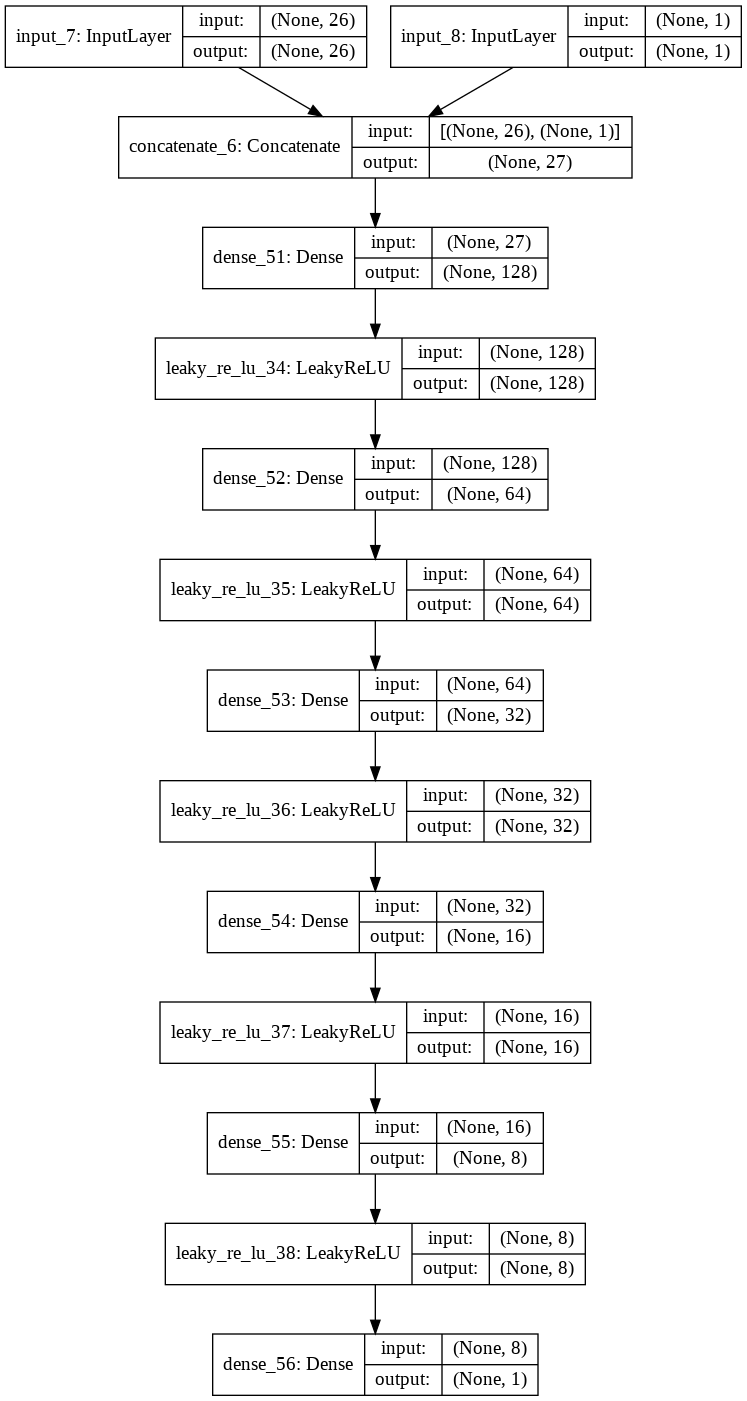

In [0]:
discriminator5 = build_discriminator(inputs_n, n_classes) #Initialize discriminator
plot_model(discriminator5, show_layer_names = True, show_shapes = True)#Plot discriminator

#### GAN
 * input is generator input
 * output is dicriminator output

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Get generator input
    generator_noise, generator_label = generator.input
    #Get generator output
    generator_output = generator.output
    #Gan output (discriminator output)
    gan_output = discriminator([generator_output, generator_label])
    #Initialize gan
    model = Model([generator_noise, generator_label], gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

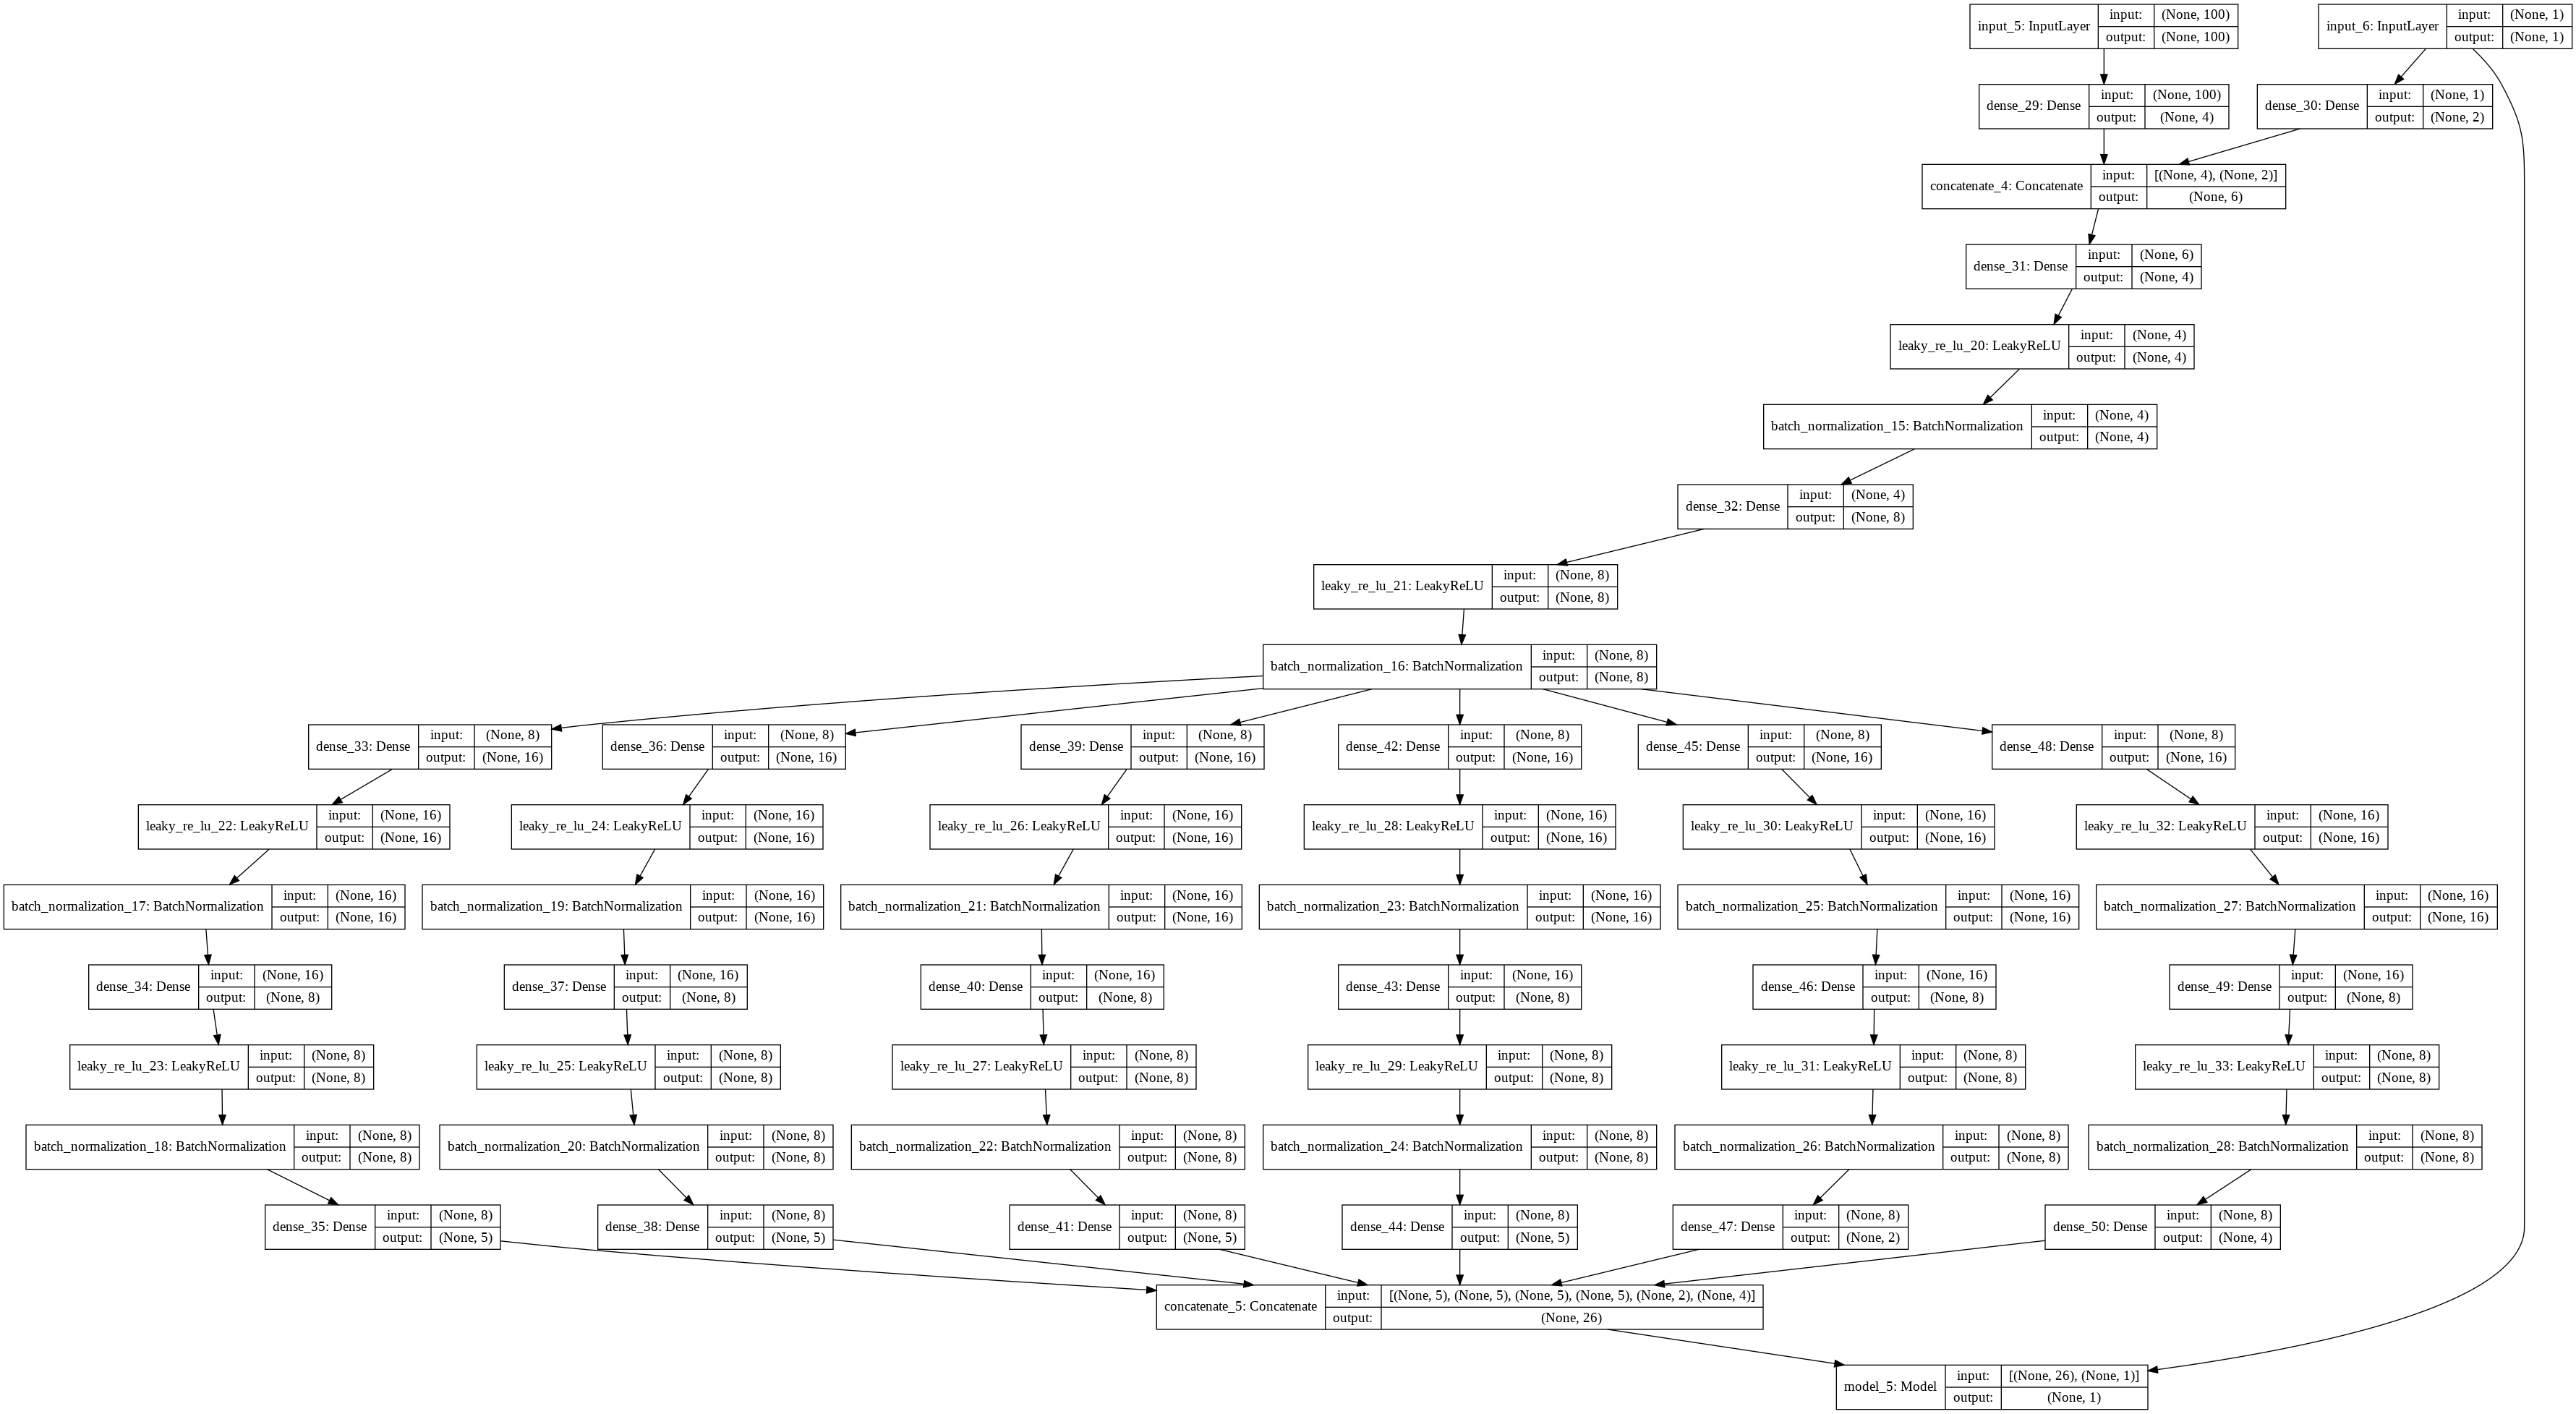

In [0]:
gan5 = build_gan(generator5, discriminator5) #Initialize GAN
plot_model(gan5, show_layer_names = True, show_shapes = True) #Plot GAN

CGAN training

In [0]:
def train(gan, generator, discriminator, ohe1, ohe2, ohe3, ohe4, gender_ohe, numerical_data, labels, latent_dim, n_epochs, n_batch, n_eval):
    #get half batch size to update discriminator
    half_batch = int(n_batch / 2)
    #lists for stats from the model training
    discriminator_loss = []
    generator_loss = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real data
        idx = np.random.randint(0, numerical_data.shape[0], half_batch)
        ohe1 = ohe1[idx]
        ohe2 = ohe2[idx]
        ohe3 = ohe3[idx]
        ohe4 = ohe4[idx]
        gender_ohe = gender_ohe[idx]
        numerical_data = numerical_data[idx]
        real_labels = labels[idx]
        
        #concatenate data for discriminator input (same way as the generator output)
        real_data = np.concatenate([ohe1, ohe2, ohe3, ohe4, gender_ohe, numerical_data], axis = 1)
        
        #generate fake samples from the noise and fake labels
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_labels = np.random.randint(0, 4, (half_batch, 1))
        fake_data = generator.predict([noise, fake_labels])

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch([real_data, real_labels], valid)
        d_loss_fake, _ = discriminator.train_on_batch([fake_data, fake_labels], fake)

        #append stats from training
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #train generator
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        noise_labels = np.random.randint(0, 4, (n_batch, 1))
        g_loss= gan.train_on_batch([noise, noise_labels], y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))

    #plot losses
    plt.figure(figsize = (20, 10))
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.plot(generator_loss, label = "Generator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

In [0]:
train(gan5, generator5, discriminator5, event17_ohe.values, event18_ohe.values, event19_ohe.values, event20_ohe.values, gender_ohe.values, numerical_data_rescaled, labels, latent_dim = 100, n_epochs = 20000, n_batch = 2575, n_eval = 100)

Epoch: 100 [Discriminator loss: 0.030941] [Generator loss: 3.399959]
Epoch: 200 [Discriminator loss: 0.104493] [Generator loss: 2.835105]
Epoch: 300 [Discriminator loss: 0.030399] [Generator loss: 3.643715]
Epoch: 400 [Discriminator loss: 0.013073] [Generator loss: 4.369587]
Epoch: 500 [Discriminator loss: 0.006619] [Generator loss: 4.933706]
Epoch: 600 [Discriminator loss: 0.004745] [Generator loss: 5.703031]
Epoch: 700 [Discriminator loss: 0.002376] [Generator loss: 6.234666]
Epoch: 800 [Discriminator loss: 0.001290] [Generator loss: 6.790228]
Epoch: 900 [Discriminator loss: 0.000873] [Generator loss: 7.195805]
Epoch: 1000 [Discriminator loss: 0.000679] [Generator loss: 7.516388]
Epoch: 1100 [Discriminator loss: 0.000860] [Generator loss: 7.462957]
Epoch: 1200 [Discriminator loss: 0.000676] [Generator loss: 7.689208]
Epoch: 1300 [Discriminator loss: 0.000573] [Generator loss: 7.822417]
Epoch: 1400 [Discriminator loss: 0.000471] [Generator loss: 8.082445]
Epoch: 1500 [Discriminator lo

KeyboardInterrupt: ignored

In [0]:
def generate_data(class_num, num_samples):
    noise = np.random.normal(0, 1, (num_samples, 100))
    labels = np.asarray([class_num for _ in range(num_samples)]).reshape(-1, 1)
    generated_data = generator5.predict([noise ,labels])
    return generated_data

In [0]:
le.classes_

In [0]:
df.bmi_class.value_counts() #count label variables from the original data

In [0]:
ov = generate_data(0, 5590) 
he = generate_data(1, 4112)
so = generate_data(2, 256)
uv = generate_data(3, 42)

In [0]:
zero = np.random.randint(0,1, (len(ov), 1))
one = np.random.randint(1,2, (len(he), 1))
two = np.random.randint(2,3, (len(so), 1))
three = np.random.randint(3,4, (len(uv), 1))

In [0]:
ov = np.append(ov, zero, axis = 1)
he = np.append(he, one, axis = 1)
so = np.append(so, two, axis = 1)
uv = np.append(uv, three, axis = 1)

In [0]:
# original data
og_df = pd.concat([event17_ohe, event18_ohe, event19_ohe, event20_ohe, gender_ohe, numerical_data, df.bmi_class], axis = 1)
og_df

In [0]:
#generated data
generate_data = np.concatenate([ov, he, so, uv])
generate_data.shape

In [0]:
#generated data to dataframe
gen_df = pd.DataFrame(data = generate_data, columns = og_df.columns)
gen_df

In [0]:
#round data
gen_df.iloc[:, :22] = np.round(gen_df.iloc[:, :22])
gen_df.iloc[:, 22:26] = mms.inverse_transform(gen_df.iloc[:, 22:26])
gen_df

### Comaparing original and generated data
 * Normal distribution
 * mean, std, var
 * correlation matrix

In [0]:
for column in gen_df.iloc[:, 22:26]:
    print(column, "Normal distribution")
    normal_distribution(og_df[column], gen_df[column])

In [0]:
#correlation matrix compareing
print("Original data")
plt.figure(figsize = (30, 20))
sns.heatmap(og_df.corr(), annot = True)

In [0]:
print("Generated data")
plt.figure(figsize = (30, 20))
sns.heatmap(gen_df.corr(), annot = True)